# Data Analysis

The purpose of this file is to:
- Identify any simulation runs which are not reliable (off by many orders of magnitude, unphysical behavior). Was implemented for BAM and THC, but didn't seem needed for the other Codes. 
- Clean the data by trimming the data to the first peak of the oscillation in the real part of the strain, and then translating the time and phase to start at this new starting point.
- Identify the merger time (time of max amplitude) and related parameters (i.e. merger frequency ($f_{mrg}$) and merger amplitude)
- Identify the maximum frequency and related parmeters (time of max frequency)

In [1]:
#Import Needed Packages
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy import signal
import os
from scipy.signal import find_peaks

## Initial Test

**Note For BAM and THC:** As can be seen by looking through the data files, some of the strain data has 7 columns and the rest (the majority) have 9 columns. The difference between these is whether or not they have the Redh/M and Imdh/M columns, which are not extremely important for our purposes.

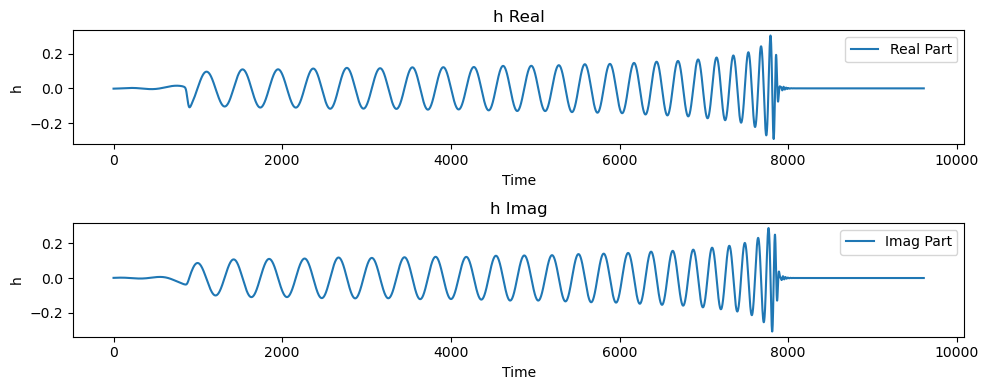

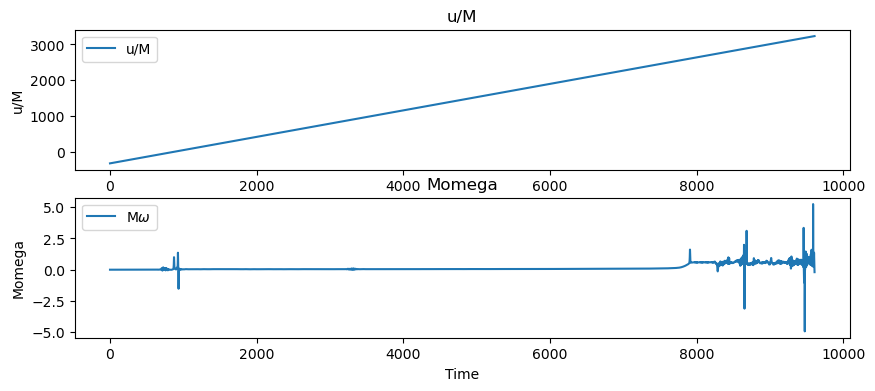

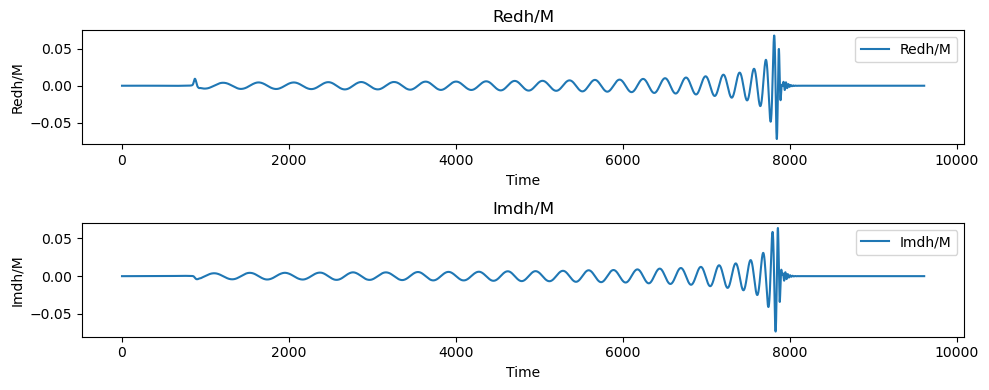

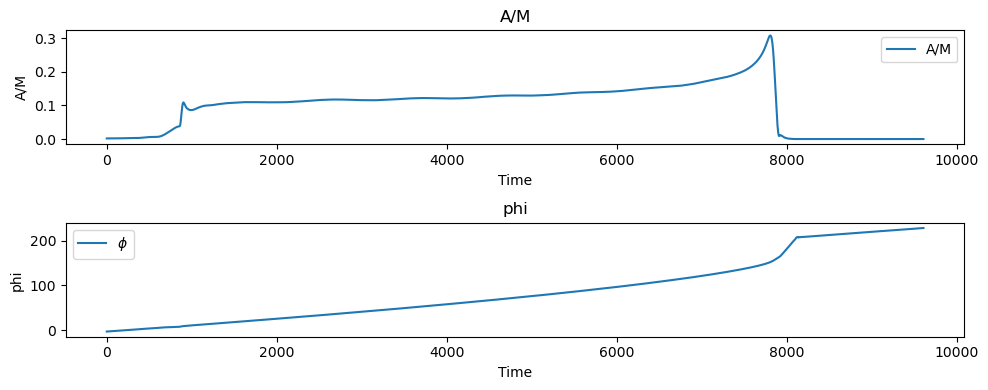

<function matplotlib.pyplot.close(fig=None)>

In [2]:
# Read one file with 9 columns to test

df = pd.read_csv('./BAM_Catalog/Strain/R02/BAM0001_2B_1350_1350_h_r850.txt', header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)

plt.figure(figsize=(10, 4))

# Plotting subplots (one for each column except the time, t)
plt.subplot(2, 1, 1) # 2 rows, 1 column, first subplot
plt.plot(df['t'], df['Reh/M'], label='Real Part')
plt.xlabel('Time')
plt.ylabel('h')
plt.title('h Real')
plt.legend()

plt.subplot(2, 1, 2) # 2 rows, 1 column, second subplot
plt.plot(df['t'], df['Imh/M'], label='Imag Part')
plt.xlabel('Time')
plt.ylabel('h')
plt.title('h Imag')
plt.legend()


plt.tight_layout()
plt.show()
plt.close


plt.figure(figsize=(10, 4))


plt.subplot(2, 1, 1) # 2 rows, 1 column, first subplot
plt.plot(df['t'], df['u/M'], label='u/M')
plt.xlabel('Time')
plt.ylabel('u/M')
plt.title('u/M')
plt.legend()

plt.subplot(2, 1, 2) # 2 rows, 1 column, second subplot
plt.plot(df['t'], df['Momega'], label='M$\omega$')
plt.xlabel('Time')
plt.ylabel('Momega')
plt.title('Momega')
plt.legend()


plt.figure(figsize=(10, 4))


plt.subplot(2, 1, 1) # 2 rows, 1 column, first subplot
plt.plot(df['t'], df['Redh/M'], label='Redh/M')
plt.xlabel('Time')
plt.ylabel('Redh/M')
plt.title('Redh/M')
plt.legend()

plt.subplot(2, 1, 2) # 2 rows, 1 column, second subplot
plt.plot(df['t'], df['Imdh/M'], label='Imdh/M')
plt.xlabel('Time')
plt.ylabel('Imdh/M')
plt.title('Imdh/M')
plt.legend()

plt.tight_layout()
plt.show()
plt.close



plt.figure(figsize=(10, 4))


plt.subplot(2, 1, 1) # 2 rows, 1 column, first subplot
plt.plot(df['t'], df['A/M'], label='A/M')
plt.xlabel('Time')
plt.ylabel('A/M')
plt.title('A/M')
plt.legend()

plt.subplot(2, 1, 2) # 2 rows, 1 column, second subplot
plt.plot(df['t'], df['phi'], label='$\phi$')
plt.xlabel('Time')
plt.ylabel('phi')
plt.title('phi')
plt.legend()

plt.tight_layout()
plt.show()
plt.close

## Adjustments for Other Codes

Unfortunately, each of the codes have a slightly different structure to their data, and so I give a template for importing the data as a data frame for each of the other codes below. 

Note that I give some of the code's variables names that are different ('Reh' Instead of 'Reh/M') because they are not divided by mass.

In [3]:
# SACRA (Variable names are for use in this )
df = pd.read_csv('./SACRA_Catalog/Strain/Lev_182/SFHo_135_135_h', header=None, names=['t', 'Reh', 'Imh'], delim_whitespace=True)

# SpEC (or SXS)
df = pd.read_csv('./SXS_Catalog/Strain/Lev1/hMlR_136_136_h.txt', header=None, names=['t/M', 'Reh/M', 'Imh/M'], delim_whitespace=True)

# Whisky
df = pd.read_csv('./Whisky_Catalog/ALF2_1350_1350_h.txt', header=None, names=['t', 'Reh', 'Imh'], delim_whitespace=True)

# WhiskyTHC
df = pd.read_csv('./THC_Catalog/Strain/R01/THC0001_BHBlp_125_125_h.txt', header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)


### Defining Masses

We want a list of the total mass and mass ratio as we will need this in several places for computations and comparisons. We can extract this information from the file names as follows in the code below.

In [3]:
#Define empty list for masses
Mass_List = []

#Define List of BAM Equations of State
EOS_List = ['2B', '2H', 'ALF2', 'ENG', 'G2','G2k123', 'H4', 'MPA1', 'MS1', 'MS1b', 'SLy' ]

#Loop over files in path ./BAM_Catalog/Strain/R01 (i.e. BAM strain data of refinement R01)
for file in glob.glob('./BAM_Catalog/Strain/R02/*.txt'):
    
    
    iden = file.replace('./BAM_Catalog/Strain/R02\\BAM', '').replace('.txt', '')[5:]
    
    #Define list of terms in file path separated by _
    strings = iden.split('_')
    
    ##Test switching extraction radius notation (e.g. r1000) with h marker in title
    #iden = iden.replace(strings[-1], 'Null').replace(strings[-2], strings[-1]).replace('Null', strings[-2])
    #print(iden)
    
    #Remove extraction radius notation (e.g. r850) and h marker from iden string
    iden = iden.replace('_'+strings[-2], '').replace('_'+strings[-1], '')
    
    print(iden)
    
    
    EOS_id = False
    
    #Loop over EOS_List to remove EOS from iden string (so mass can be identified)
    for EOS in EOS_List:
        
        #Check if EOS in iden string
        if EOS+'_' in iden:
            
            #Remove EOS from string
            mass_id = iden.replace(EOS+'_', '')
            EOS_id = True
            #print(mass_id)
            
            #Make list of the individual masses as a string
            masses = mass_id.split('_')
            #print(masses)
            
            #Convert mass data as strings to mass data as float in solar masses
            n = len(masses[0])  #Need to use this to determine scaling as files inconsitent with number of decimals
            masses[0] = int(masses[0])/(10**(n-1))
            masses[1] = int(masses[1])/(10**(n-1))
            #print(masses)
            
            #Compute Total Mass and Mass Ratio
            Mtotal = masses[0]+masses[1]
            q = masses[1]/masses[0]
            
            #Append list of total mass and mass ratio to Mass_List
            Mass_List.append([Mtotal, q])
            
    if EOS_id == False:
        print(f"Error: No EOS Identified for {iden}")

#Check Total masses and mass ratios in Mass_List
print(Mass_List)

2B_1350_1350
2H_1350_1350
ALF2_1350_1350
ALF2_1351_1351
ALF2_1375_1375
ALF2_1450_1250
ALF2_1500_1500
ALF2_1528_1222
ALF2_1600_1600
ALF2_1650_1100
ALF2_1750_1000
ENG_1350_1350
G2_1515_1515
H4_1350_1350
H4_1351_1351
H4_1372_1372
H4_1375_1375
H4_1450_1251
H4_1500_1500
H4_1528_1222
H4_1600_1600
H4_1650_1100
H4_1750_1000
MPA1_1350_1350
MS1_1250_1450
MS1_1350_1350
MS1_1351_1351
MS1b_1350_1350
MS1b_1350_1350
MS1b_1375_1375
MS1b_1500_1000
MS1b_1500_1000
MS1b_1500_1500
MS1b_1527_1222
MS1b_1600_1600
MS1b_1650_1100
MS1b_1700_1700
MS1b_1750_1000
MS1b_1944_0944
SLy_1350_1350
SLy_1350_1350
SLy_1350_1350
SLy_1350_1350
SLy_1350_1350
SLy_1351_1351
SLy_1354_1106
SLy_1375_1375
SLy_1450_1250
SLy_1500_1000
SLy_1500_1500
SLy_1527_1222
SLy_1650_1098
SLy_1650_1098
SLy_1800_0900
SLy_1718_0982
SLy_1350_1350
SLy_1620_1080
SLy_1500_1200
MPA1_1744_1570
MPA1_1852_1481
MPA1_1655_1655
[[2.7, 1.0], [2.7, 1.0], [2.7, 1.0], [2.702, 1.0], [2.75, 1.0], [2.7, 0.8620689655172414], [3.0, 1.0], [2.75, 0.7997382198952879], [3.

## Plotting Data for Real Part, Phase, and Frequency

We have plotted the Real part for all of the files, and we will use that to figure out which data points we need to remove. This is because a small portion of the data has an amplitude off by several orders of magnitude, and it is unclear why this is the case. This was observed for THC and BAM.

./BAM_Catalog/Strain/R02\BAM0001_2B_1350_1350_h_r850.txt


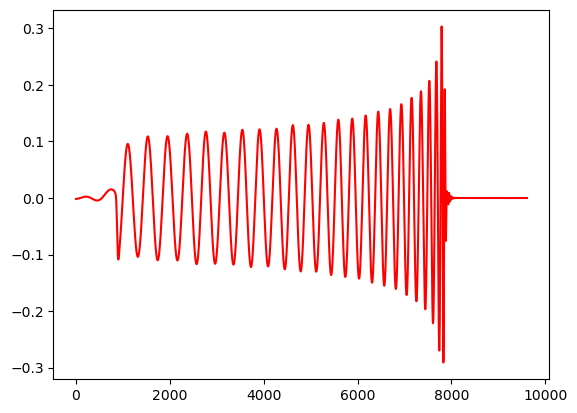

./BAM_Catalog/Strain/R02\BAM0002_2H_1350_1350_h_r900.txt


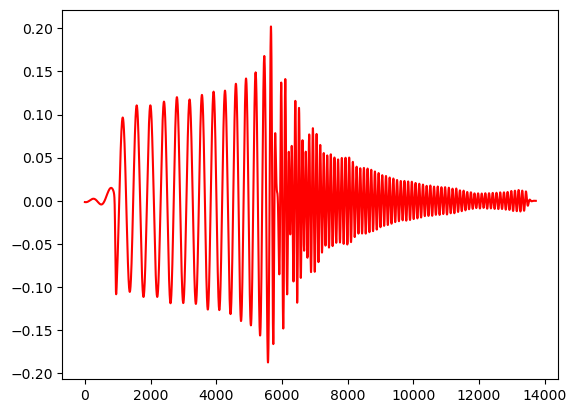

./BAM_Catalog/Strain/R02\BAM0003_ALF2_1350_1350_h_r900.txt


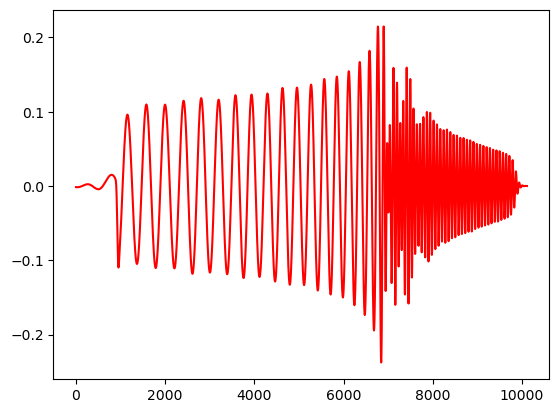

./BAM_Catalog/Strain/R02\BAM0004_ALF2_1351_1351_h_r1000.txt


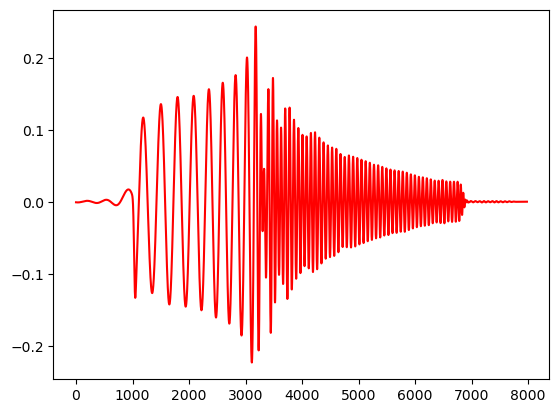

./BAM_Catalog/Strain/R02\BAM0005_ALF2_1375_1375_h_r1000.txt


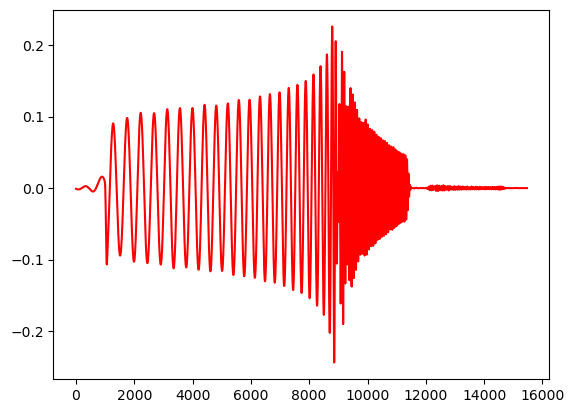

./BAM_Catalog/Strain/R02\BAM0010_ALF2_1450_1250_h_r1000.txt


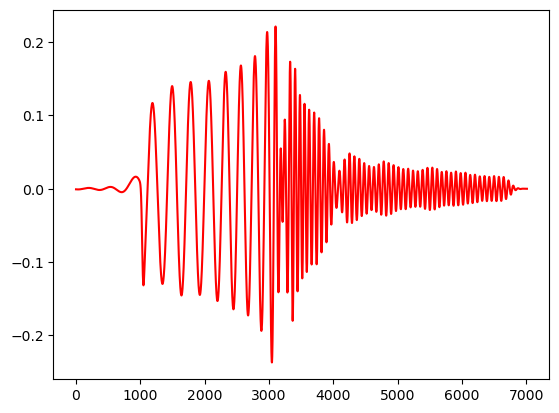

./BAM_Catalog/Strain/R02\BAM0011_ALF2_1500_1500_h_r800.txt


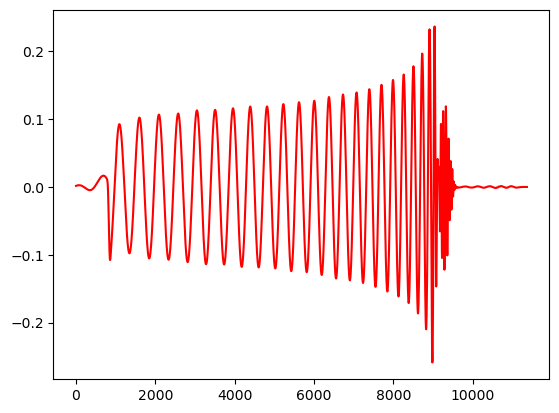

./BAM_Catalog/Strain/R02\BAM0012_ALF2_1528_1222_h_r1000.txt


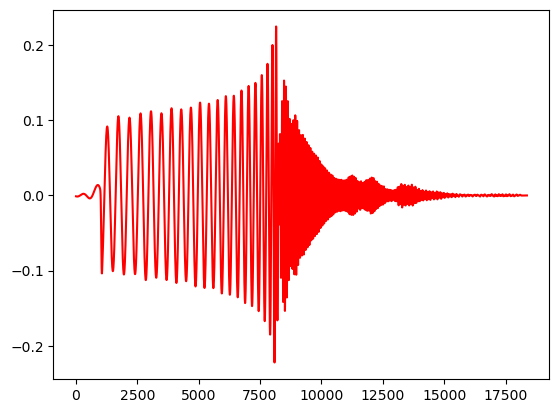

./BAM_Catalog/Strain/R02\BAM0016_ALF2_1600_1600_h_r1000.txt


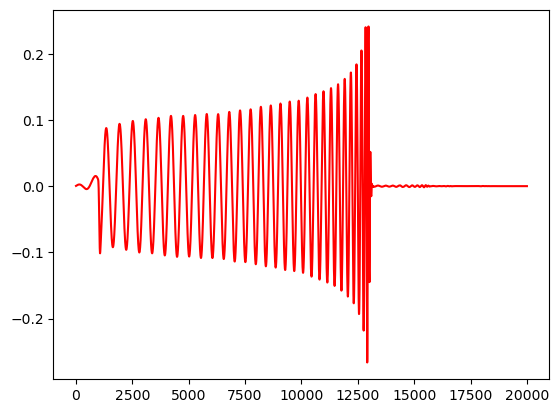

./BAM_Catalog/Strain/R02\BAM0017_ALF2_1650_1100_h_r1000.txt


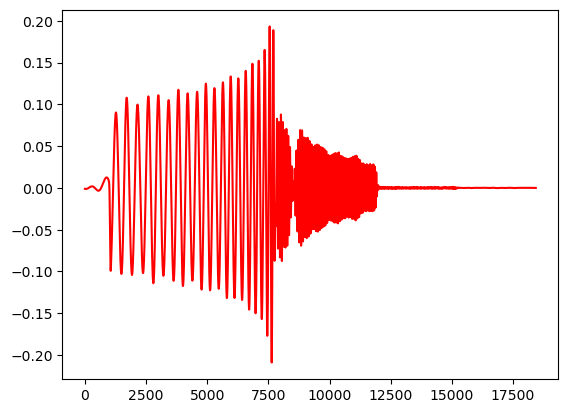

./BAM_Catalog/Strain/R02\BAM0021_ALF2_1750_1000_h_r1000.txt


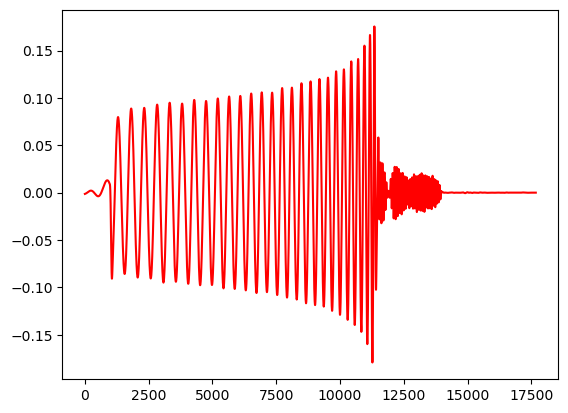

./BAM_Catalog/Strain/R02\BAM0022_ENG_1350_1350_h_r900.txt


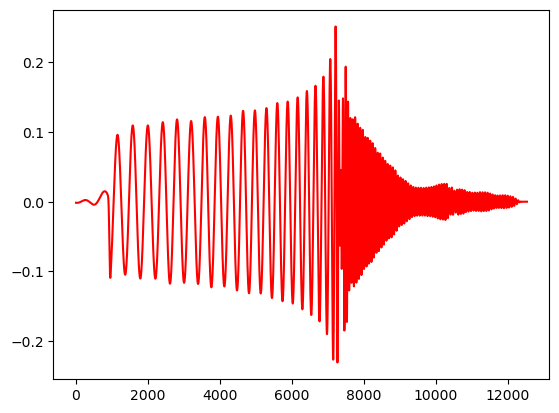

./BAM_Catalog/Strain/R02\BAM0026_G2_1515_1515_h_r400.txt


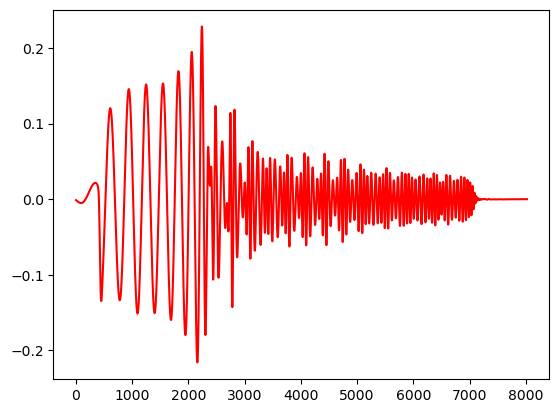

./BAM_Catalog/Strain/R02\BAM0035_H4_1350_1350_h_r900.txt


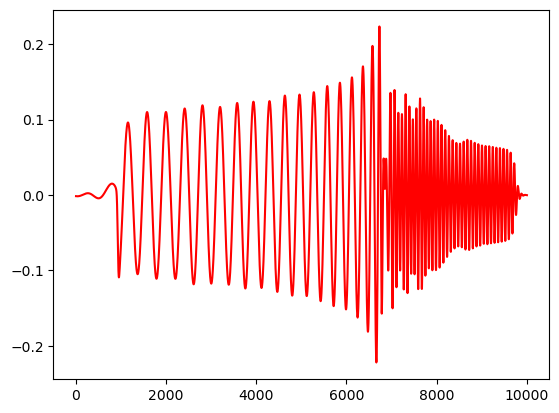

./BAM_Catalog/Strain/R02\BAM0036_H4_1351_1351_h_r1000.txt


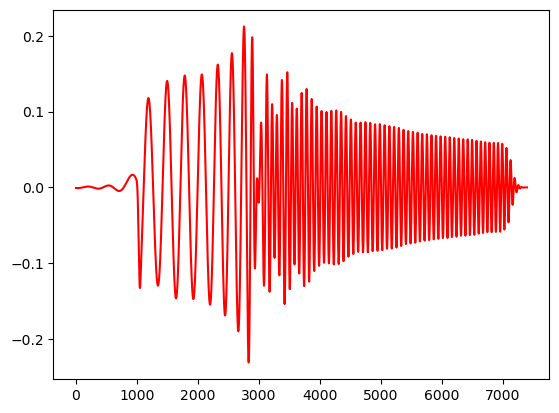

./BAM_Catalog/Strain/R02\BAM0037_H4_1372_1372_h_r1000.txt


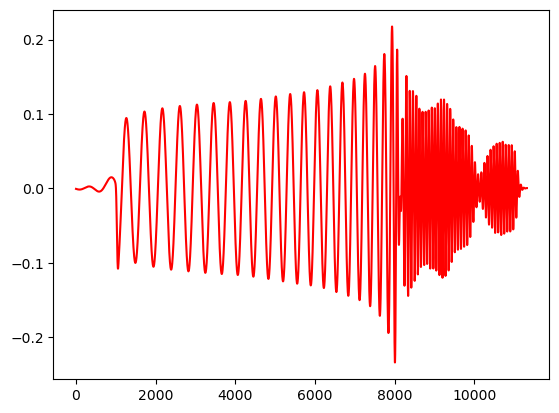

./BAM_Catalog/Strain/R02\BAM0042_H4_1375_1375_h_r1000.txt


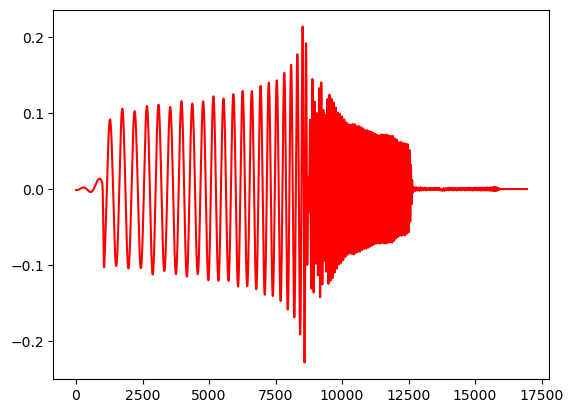

./BAM_Catalog/Strain/R02\BAM0046_H4_1450_1251_h_r1200.txt


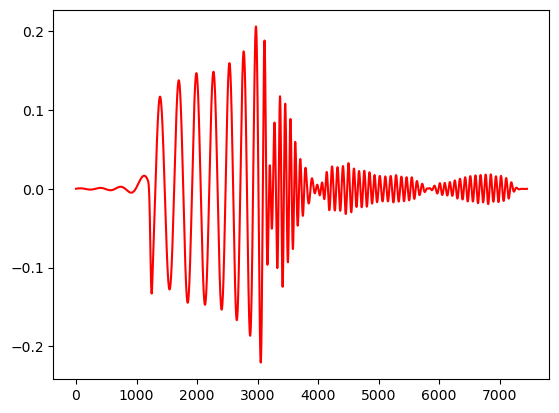

./BAM_Catalog/Strain/R02\BAM0047_H4_1500_1500_h_r1000.txt


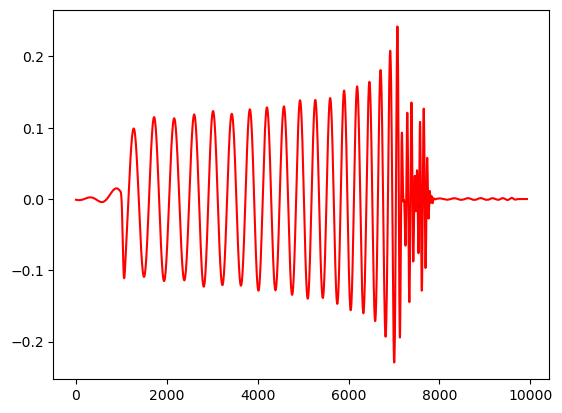

./BAM_Catalog/Strain/R02\BAM0048_H4_1528_1222_h_r1000.txt


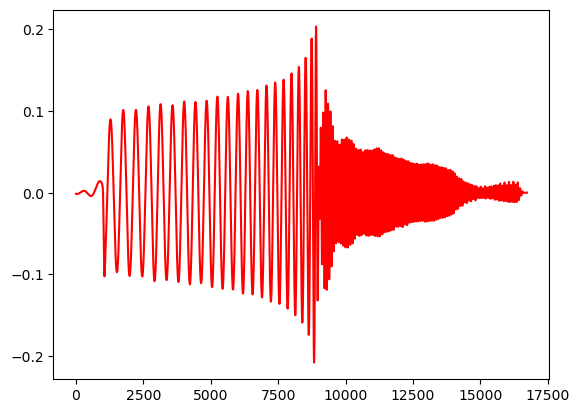

./BAM_Catalog/Strain/R02\BAM0052_H4_1600_1600_h_r1000.txt


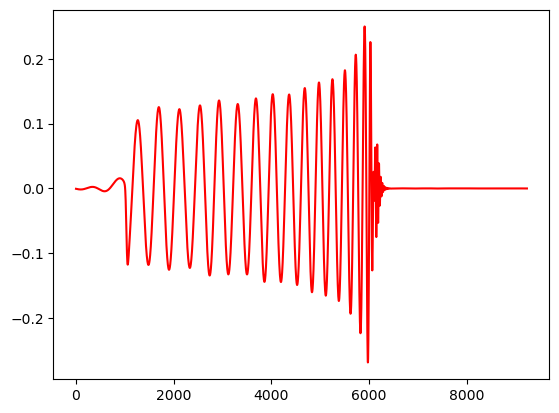

./BAM_Catalog/Strain/R02\BAM0053_H4_1650_1100_h_r1000.txt


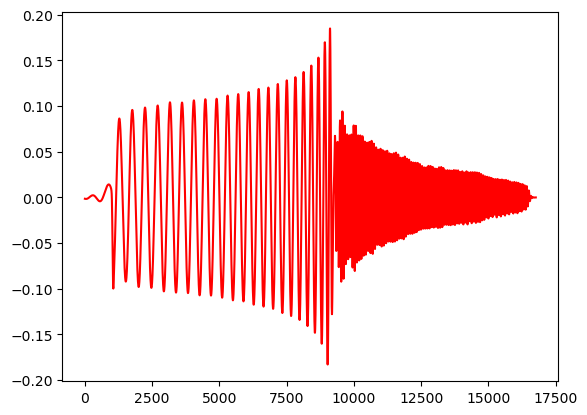

./BAM_Catalog/Strain/R02\BAM0057_H4_1750_1000_h_r1000.txt


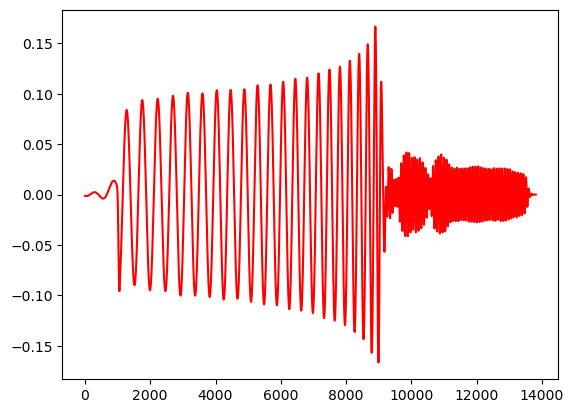

./BAM_Catalog/Strain/R02\BAM0058_MPA1_1350_1350_h_r1000.txt


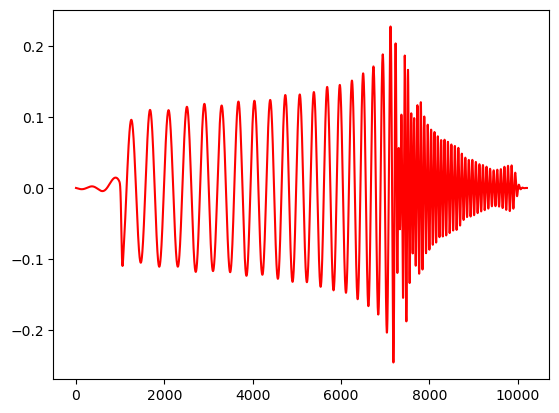

./BAM_Catalog/Strain/R02\BAM0059_MS1_1250_1450_h_r1000.txt


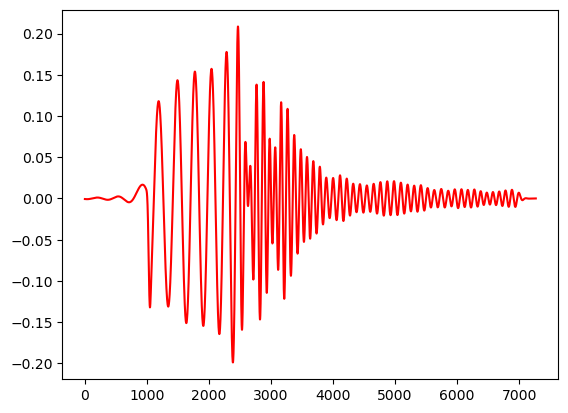

./BAM_Catalog/Strain/R02\BAM0060_MS1_1350_1350_h_r900.txt


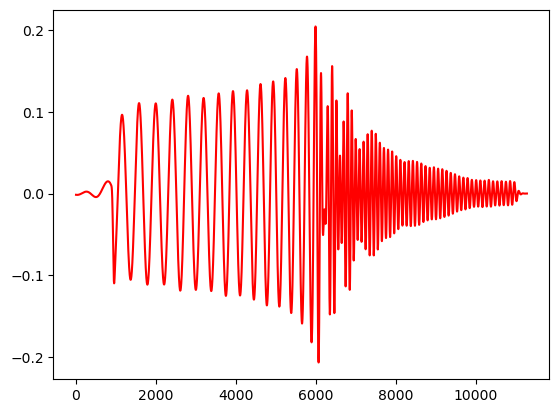

./BAM_Catalog/Strain/R02\BAM0061_MS1_1351_1351_h_r1000.txt


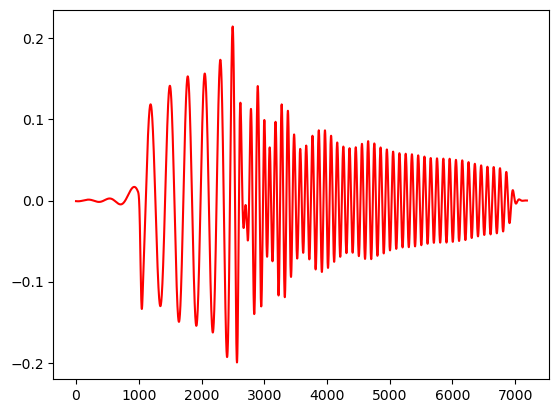

./BAM_Catalog/Strain/R02\BAM0064_MS1b_1350_1350_h_r1400.txt


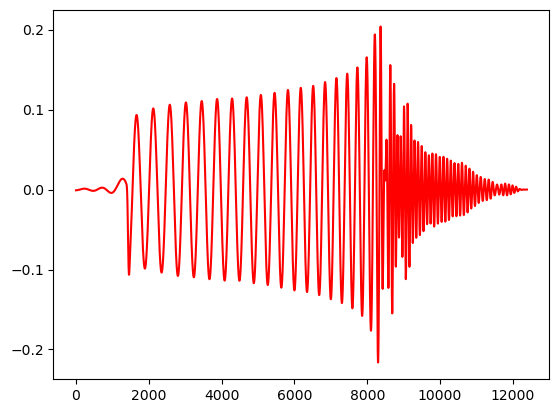

./BAM_Catalog/Strain/R02\BAM0065_MS1b_1350_1350_h_r1000.txt


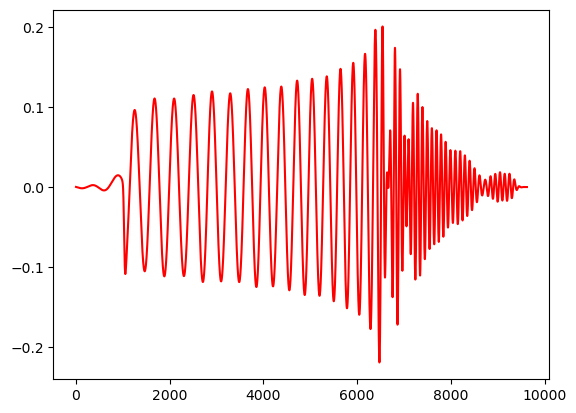

./BAM_Catalog/Strain/R02\BAM0070_MS1b_1375_1375_h_r1000.txt


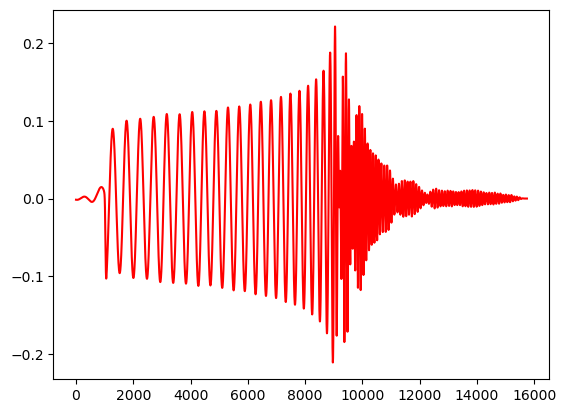

./BAM_Catalog/Strain/R02\BAM0081_MS1b_1500_1000_h_r1000.txt


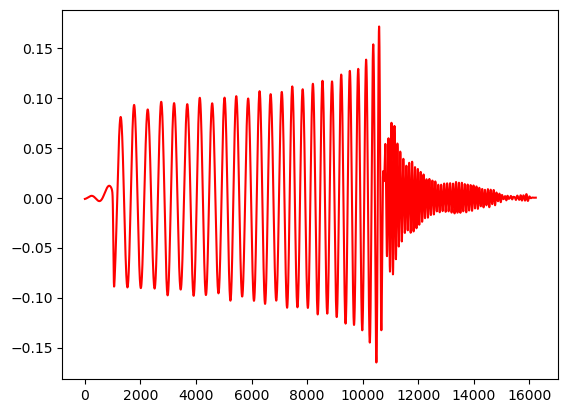

./BAM_Catalog/Strain/R02\BAM0087_MS1b_1500_1000_h_r1000.txt


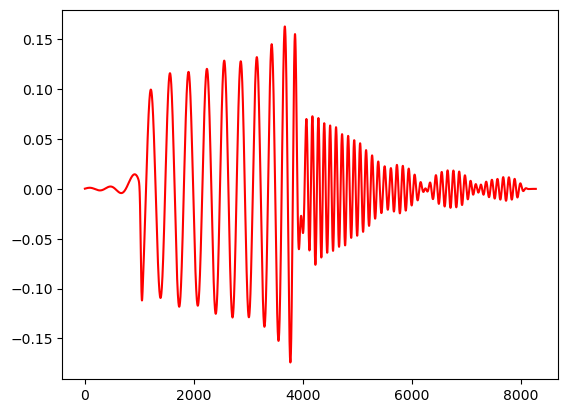

./BAM_Catalog/Strain/R02\BAM0088_MS1b_1500_1500_h_r1000.txt


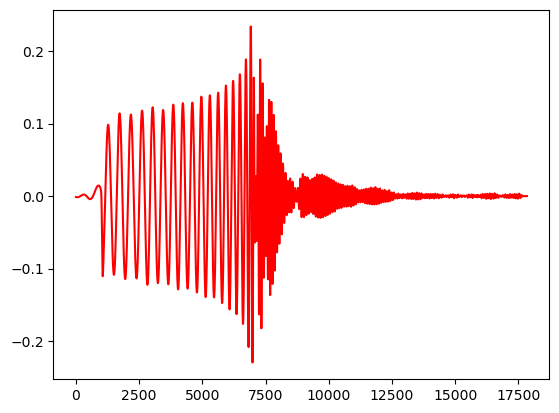

./BAM_Catalog/Strain/R02\BAM0089_MS1b_1527_1222_h_r1000.txt


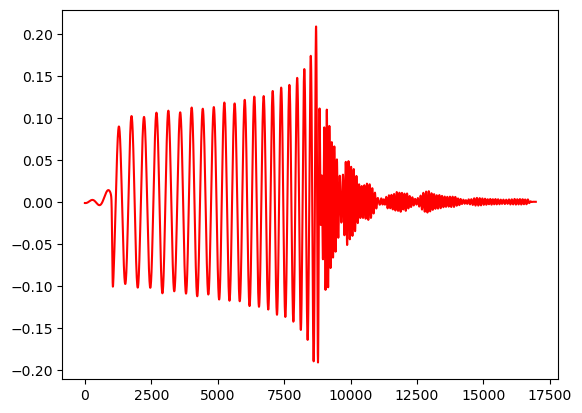

./BAM_Catalog/Strain/R02\BAM0090_MS1b_1600_1600_h_r1000.txt


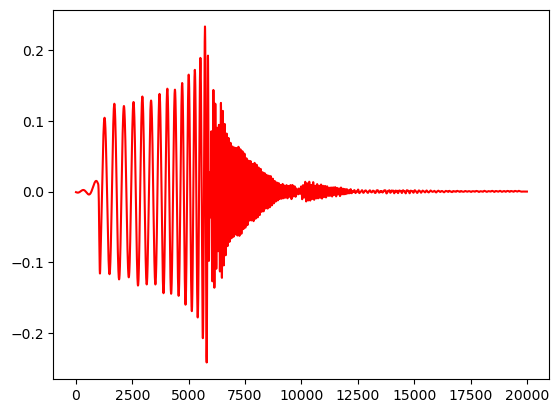

./BAM_Catalog/Strain/R02\BAM0091_MS1b_1650_1100_h_r1000.txt


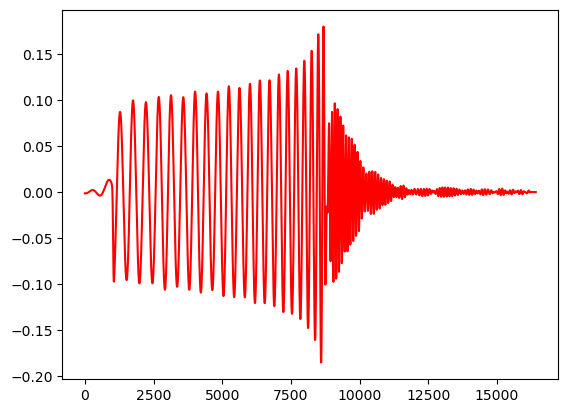

./BAM_Catalog/Strain/R02\BAM0092_MS1b_1700_1700_h_r1000.txt


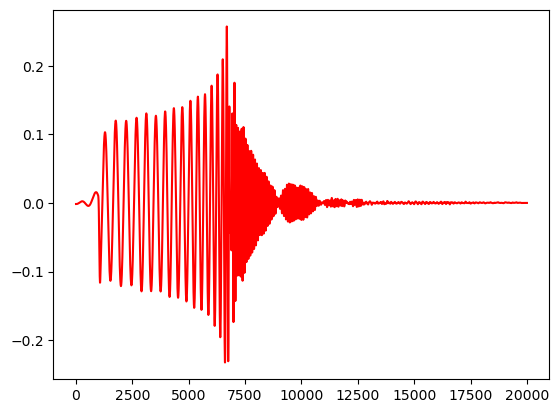

./BAM_Catalog/Strain/R02\BAM0093_MS1b_1750_1000_h_r1000.txt


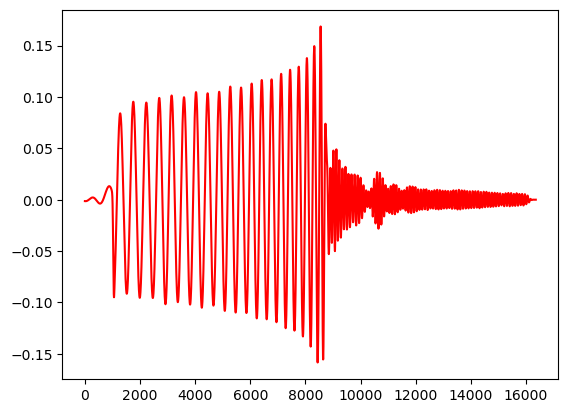

./BAM_Catalog/Strain/R02\BAM0094_MS1b_1944_0944_h_r1000.txt


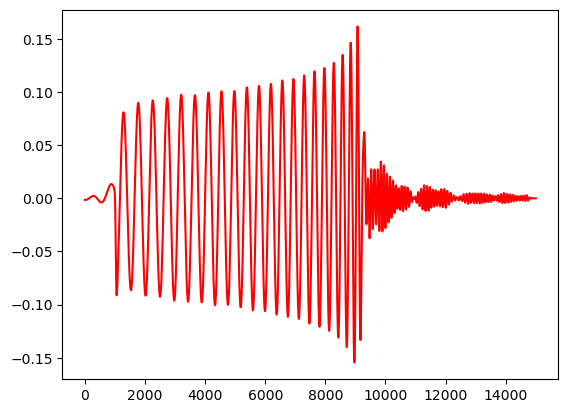

./BAM_Catalog/Strain/R02\BAM0095_SLy_1350_1350_h_r1000.txt


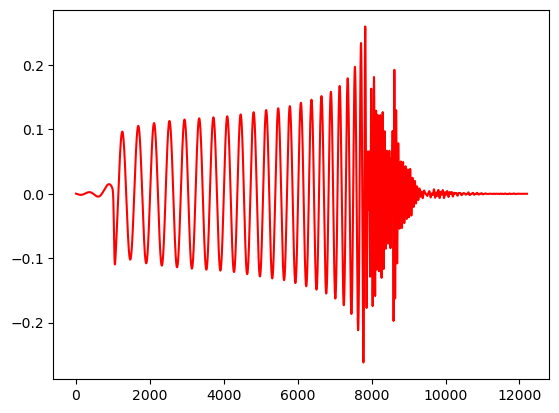

./BAM_Catalog/Strain/R02\BAM0096_SLy_1350_1350_h_r1000.txt


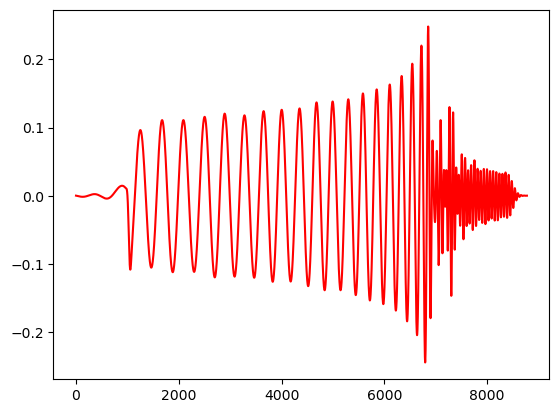

./BAM_Catalog/Strain/R02\BAM0097_SLy_1350_1350_h_r1000.txt


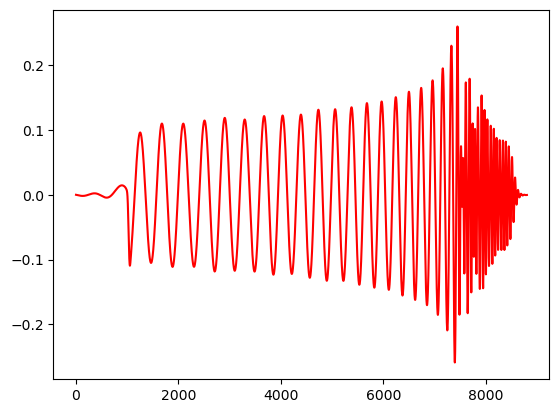

./BAM_Catalog/Strain/R02\BAM0099_SLy_1350_1350_h_r650.txt


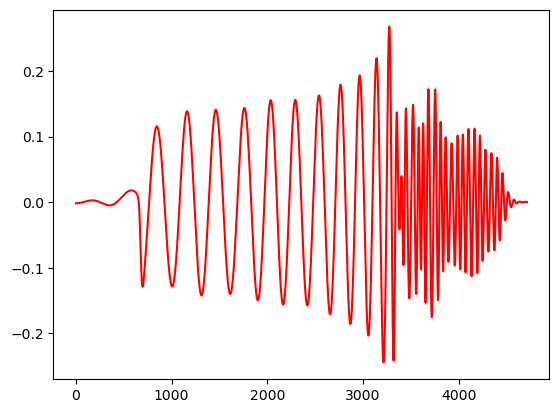

./BAM_Catalog/Strain/R02\BAM0100_SLy_1350_1350_h_r600.txt


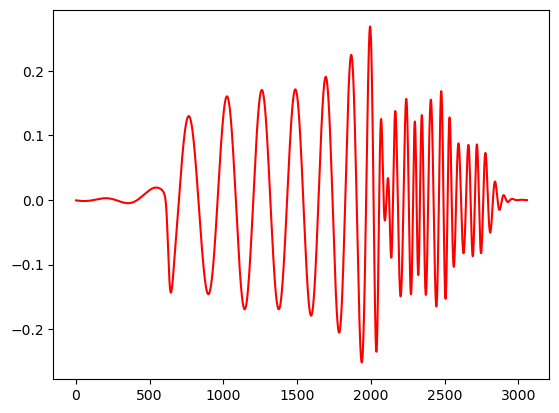

./BAM_Catalog/Strain/R02\BAM0103_SLy_1351_1351_h_r1000.txt


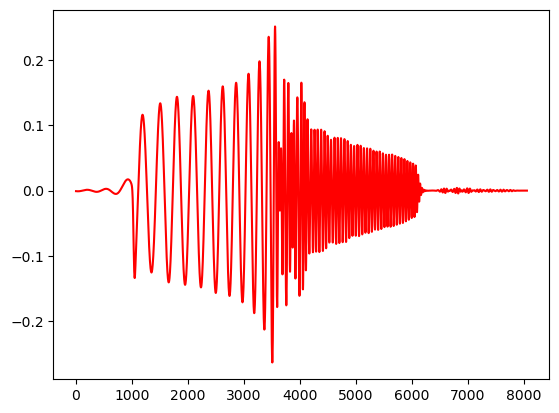

./BAM_Catalog/Strain/R02\BAM0107_SLy_1354_1106_h_r1000.txt


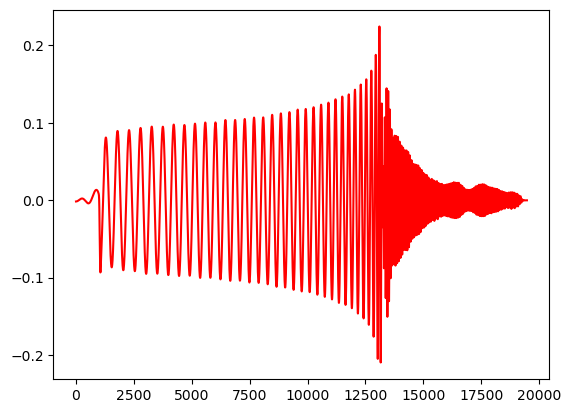

./BAM_Catalog/Strain/R02\BAM0120_SLy_1375_1375_h_r1000.txt


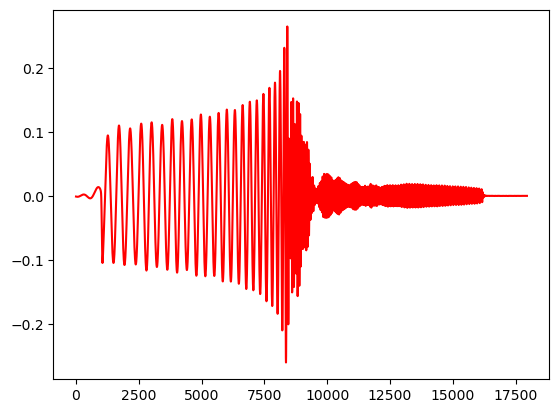

./BAM_Catalog/Strain/R02\BAM0123_SLy_1450_1250_h_r1000.txt


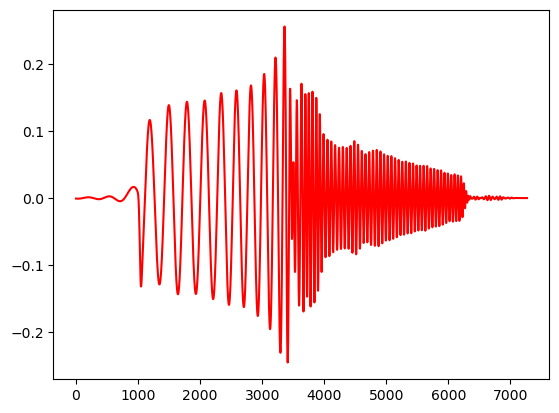

./BAM_Catalog/Strain/R02\BAM0124_SLy_1500_1000_h_r1000.txt


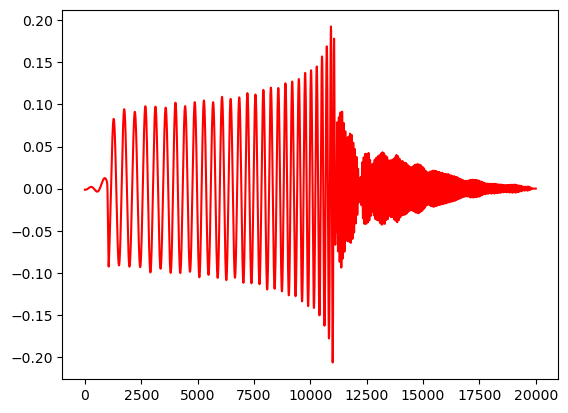

./BAM_Catalog/Strain/R02\BAM0125_SLy_1500_1500_h_r1000.txt


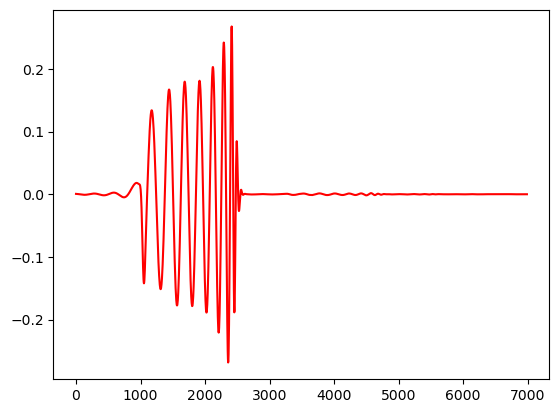

./BAM_Catalog/Strain/R02\BAM0126_SLy_1527_1222_h_r1000.txt


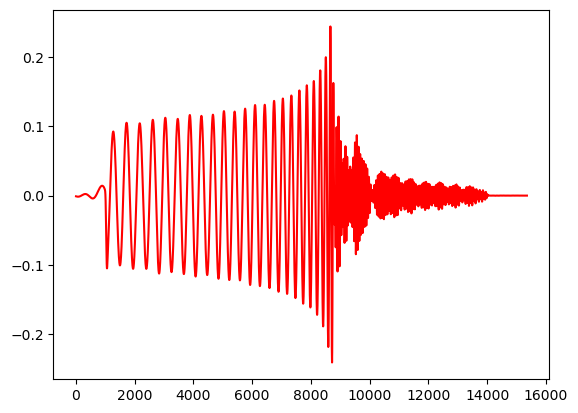

./BAM_Catalog/Strain/R02\BAM0127_SLy_1650_1098_h_r1000.txt


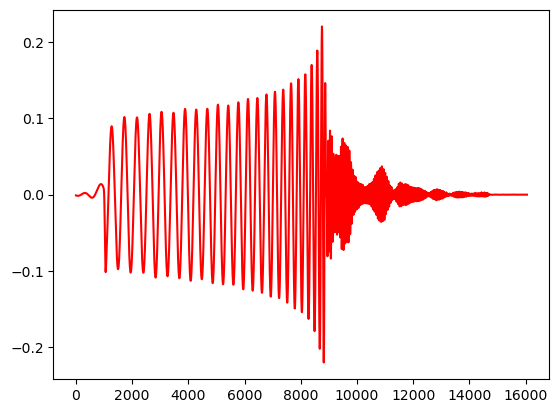

./BAM_Catalog/Strain/R02\BAM0128_SLy_1650_1098_h_r1000.txt


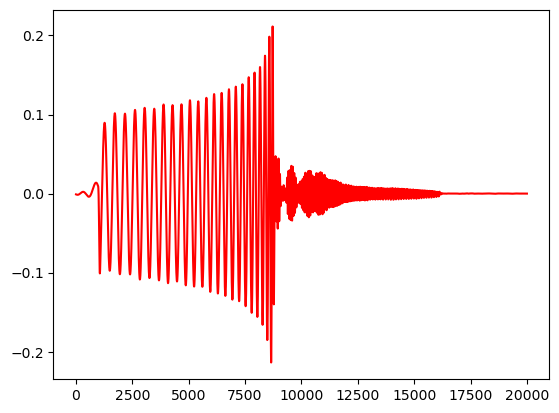

./BAM_Catalog/Strain/R02\BAM0130_SLy_1800_0900_h_r900.txt


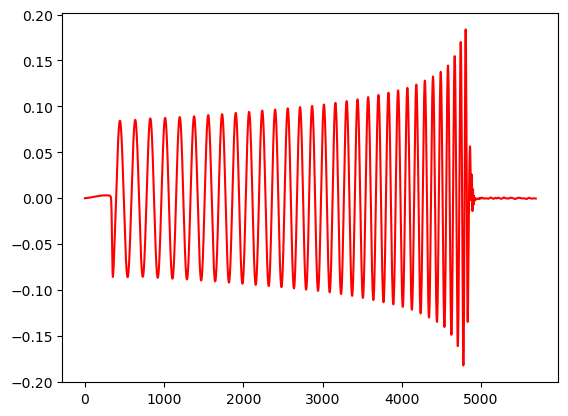

./BAM_Catalog/Strain/R02\BAM0131_SLy_1718_0982_h_r900.txt


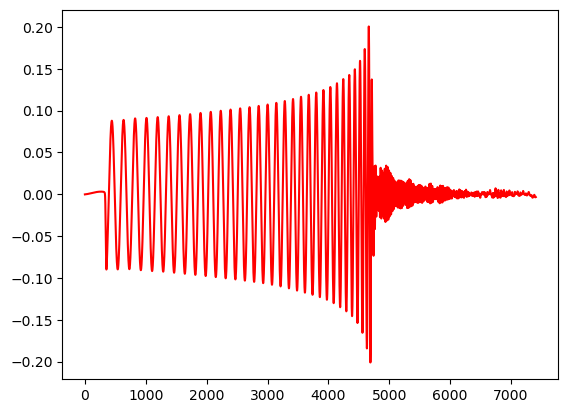

./BAM_Catalog/Strain/R02\BAM0132_SLy_1350_1350_h_r1400.txt


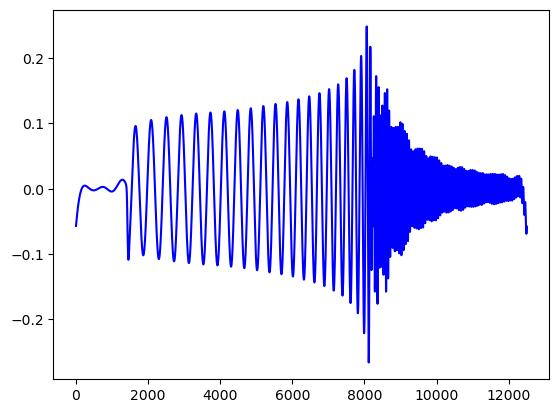

./BAM_Catalog/Strain/R02\BAM0136_SLy_1620_1080_h_r900.txt


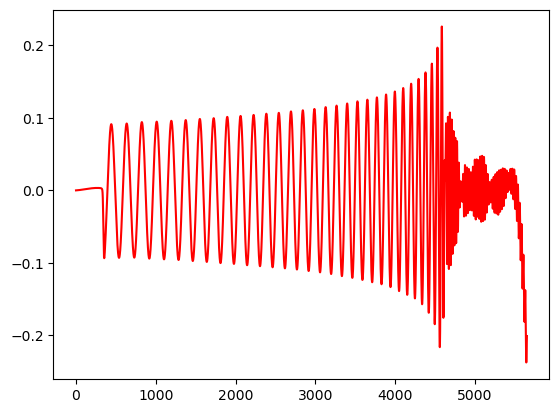

./BAM_Catalog/Strain/R02\BAM0137_SLy_1500_1200_h_r900.txt


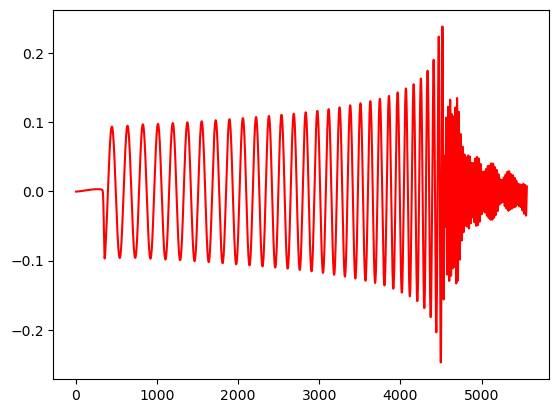

./BAM_Catalog/Strain/R02\BAM0138_MPA1_1744_1570_h_r850.txt


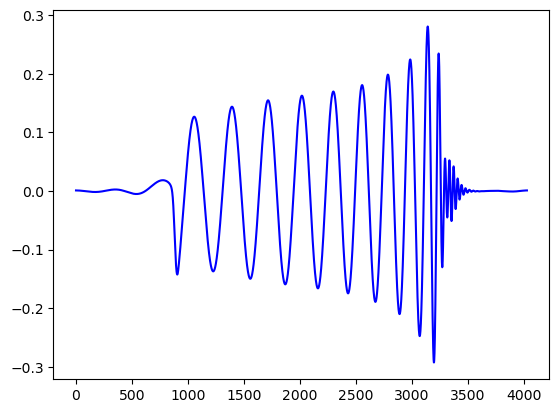

./BAM_Catalog/Strain/R02\BAM0139_MPA1_1852_1481_h_r900.txt


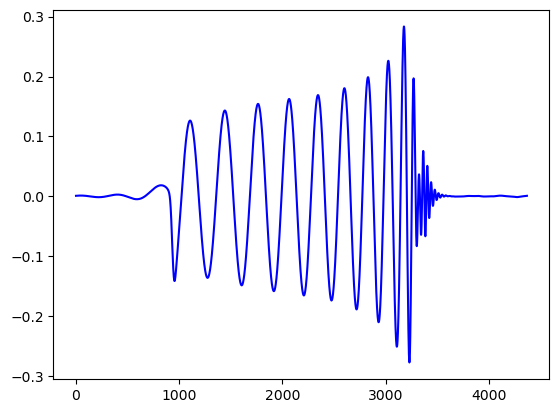

./BAM_Catalog/Strain/R02\BAM0140_MPA1_1655_1655_h_r850.txt


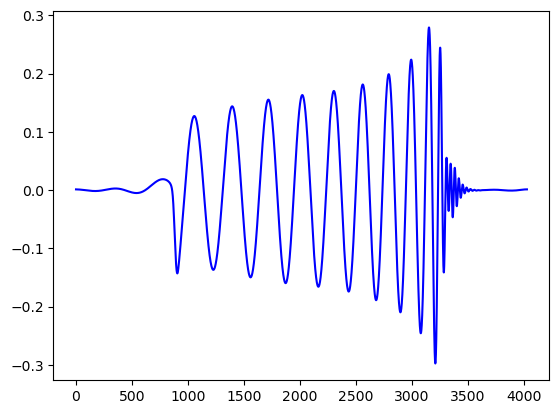

In [4]:

#Loop over data files in BAM Strain R01 path
for file in glob.glob('./BAM_Catalog/Strain/R02/*.txt'):
    print(file)
    
    #Initial import to check number of columns
    df_test = pd.read_csv(file, delim_whitespace = True)
    
    
    plt.figure()
    
    #Check if number of colums is 9
    if len(df_test.columns) == 9:
        
        #Read data for data with 9 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        #print(9)
        
        #Plot Real part versus time t
        plt.plot(df['t'], df['Reh/M'],color='r')  #, alpha=0.1)
        
        
    elif len(df_test.columns) == 7:  #Check if number of columns is 7
        
        #Read Data for data file with 7 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Re', 'Im', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        #print(7)
        
        #Plot Real part versus time t
        plt.plot(df['t'], df['Re'],color='b')
    else:
        print('Error: Number of Columns Not Identified')

    plt.show()
    plt.close()
        
#plt.title('WhiskyTHC Real Part vs. Code Time')


In [5]:
#Check to find the ones that are clearly not right to remove (Mainly ones several orders off, not over enough time, or with unphysical behaviors)

#Create empty list to append with identifiers for bad runs
Bad_File_List = []

#Loop over data files in BAM Strain R01 path
for file in glob.glob('./BAM_Catalog/Strain/R02/*.txt'):
    
    #Initial import to check number of columns
    df_test = pd.read_csv(file, delim_whitespace = True)
    
    #Check if number of columns is 9 or 7
    if len(df_test.columns) == 9:
        
        #Read data for file with 9 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        #If real part is less than 0.1 or 1e-5 add to Bad_File_List
        if max(df['Reh/M']) <= 1e-5:
            print('<=1e-5', file, ',', max(df['Reh/M']), ', r')
            Bad_File_List.append(file.replace('./BAM_Catalog/Strain/R02\\','').replace('.txt','').split('_')[0])
        elif max(df['Reh/M']) <= 0.1:
            print('< 0.1', file, ',', max(df['Reh/M']), ', r')
            Bad_File_List.append(file.replace('./BAM_Catalog/Strain/R02\\','').replace('.txt','').split('_')[0])
            
    if len(df_test.columns) == 7:
        
        #Read data for file with 7 columns 
        df = pd.read_csv(file, header=None, names=['u/M', 'Re', 'Im', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        #If real part is less than 0.1 or 1e-5 add to Bad_File_List
        if max(df['Re']) <= 1e-5:
            print('<=1e-5', file, ',', max(df['Re']), ', b')
            Bad_File_List.append(file.replace('./BAM_Catalog/Strain/R02\\','').replace('.txt','').split('_')[0])
        elif max(df['Re']) <= 0.1:
            print('< 0.1', file, ',', max(df['Re']), ', b')
            Bad_File_List.append(file.replace('./BAM_Catalog/Strain/R02\\','').replace('.txt','').split('_')[0])
            


    # Add additional files for other reasons if necessary
    add_remove = True
    if add_remove == True:

        #Template for adding to Bad_File_List for removal/exclusion in the future
        if 'BAM0131' in file:
            Bad_File_List.append(file.replace('./BAM_Catalog/Strain/R02\\','').replace('.txt','').split('_')[0])
        if 'BAM0132' in file:
            Bad_File_List.append(file.replace('./BAM_Catalog/Strain/R02\\','').replace('.txt','').split('_')[0])
        if 'BAM0136' in file:
            Bad_File_List.append(file.replace('./BAM_Catalog/Strain/R02\\','').replace('.txt','').split('_')[0])
        if 'BAM0137' in file:
            Bad_File_List.append(file.replace('./BAM_Catalog/Strain/R02\\','').replace('.txt','').split('_')[0])


print()
print(Bad_File_List)
#Bad_File_List will be used later to remove the data that is not good.


['BAM0131', 'BAM0132', 'BAM0136', 'BAM0137']


### Plot Amplitude

./BAM_Catalog/Strain/R02\BAM0046_H4_1450_1251_h_r1200.txt


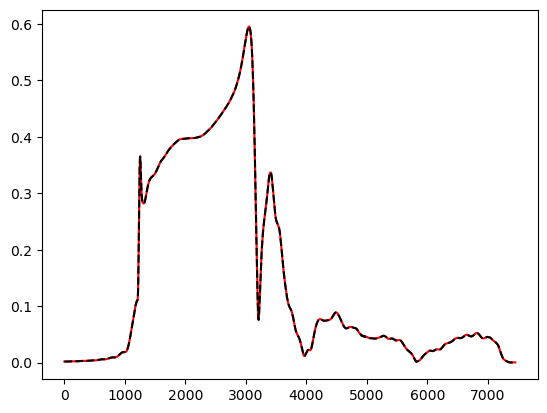

In [6]:
#Define id for which one to plot (Defined from the THC and BAM Run Number. For others just use EOS_M1_M2)
BAM_id = '0046'

#Set an index
i=0

#Loop over files
for file in glob.glob('./BAM_Catalog/Strain/R02/*.txt'):
    
    
    #Initial import to check number of columns
    df_test = pd.read_csv(file, delim_whitespace = True)
    
    #Check if number of columns is 9 or 7
    if len(df_test.columns) == 9:
        
        #Read data for datafile with 9 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        #Compute Amplitude (Note we have to multiply by the total mass)
        df['amplitude'] = np.sqrt((df['Reh/M']**2)+(df['Imh/M']**2))*Mass_List[i][0]
        
        
        #Plot amplitude of run corresponding to BAM_id
        if BAM_id in file:
            print(file)
            
            plt.figure()
            plt.plot(df['t'], df['amplitude'], color='r')
            plt.plot(df['t'], df['A/M']*Mass_List[i][0], color='k', linestyle='dashed')
            plt.show()
            plt.close()
            
        
    elif len(df_test.columns) == 7:
        
        #Read data for datafile with 7 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Re', 'Im', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        #Compute Amplitude (Note we have to multiply by the total mass)
        df['amplitude'] = np.sqrt((df['Re']**2)+(df['Im']**2))*Mass_List[i][0]
        
        
        #Plot amplitude of run corresponding to BAM_id
        if BAM_id in file:
            print(file)
            
            plt.figure()
            plt.plot(df['t'], df['amplitude'], color='b')
            plt.plot(df['t'], df['A/M']*Mass_List[i][0], color='turquoise', linestyle='dashed')
            plt.show()
            plt.close()
        
    else:
        #Note error if number of columns is not 9 or 7
        print('Error: Number of Columns Not Identified')

    
    
    #Update index
    i = i+1
        
#plt.title('WhiskyTHC Real Part vs. Code Time')

### Plot Phase

./BAM_Catalog/Strain/R02\BAM0046_H4_1450_1251_h_r1200.txt


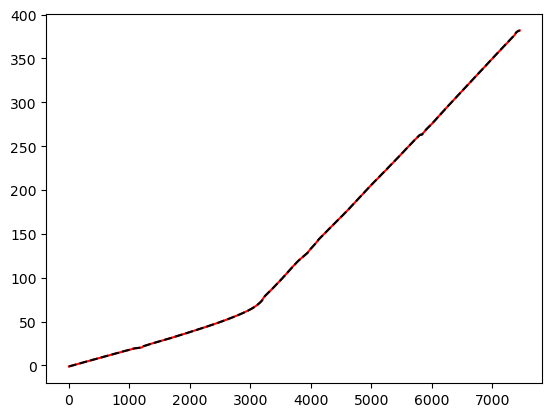

In [7]:
#Define id for which one to plot 
BAM_id = '0046'

#Loop over files in path
for file in glob.glob('./BAM_Catalog/Strain/R02/*.txt'):
    
    
    #Initial import to check number of columns
    df_test = pd.read_csv(file, delim_whitespace = True)
    
    #Check if data file has 9 or 7 columns
    if len(df_test.columns) == 9:
        
        #Read data for datafile with 9 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        
        #Compute Phase
        df['phase_raw'] = -np.arctan2(df['Imh/M'], df['Reh/M'])
        #Unwrap to convert to continuously increasing form rather than modulo pi form
        df['phase'] = np.unwrap(df['phase_raw']) 
        #Drop raw phase (i.e. phase modulo pi)
        df.drop(['phase_raw'], axis=1, inplace=True)
        
        #Plot phase for run corresponding to chosen BAM_id
        if BAM_id in file:
            print(file)
            
            plt.figure()
            plt.plot(df['t'], df['phase'], color='r')
            plt.plot(df['t'], df['phi'], color='k', linestyle='dashed')
            plt.show()
            plt.close()
        
        
    elif len(df_test.columns) == 7:
        
        #Read data for datafile with 7 columns 
        df = pd.read_csv(file, header=None, names=['u/M', 'Re', 'Im', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        
        #Compute Phase
        df['phase_raw'] = -np.arctan2(df['Im'], df['Re'])
        #Unwrap to convert to continuously increasing form rather than modulo pi form
        df['phase'] = np.unwrap(df['phase_raw'])
        #Drop raw phase (i.e. phase modulo pi)
        df.drop(['phase_raw'], axis=1, inplace=True)
        
        #Plot phase for run corresponding to chosen BAM_id
        if BAM_id in file:
            print(file)
            
            plt.figure()
            plt.plot(df['t'], df['phase'], color='b')
            plt.plot(df['t'], df['phi'], color='turquoise', linestyle='dashed')
            plt.show()
            plt.close()
        
    else:
        #Note error if number of columns is not 9 or 7
        print('Error: Number of Columns Not Identified')

        
#plt.title('WhiskyTHC Real Part vs. Code Time')


### Plot Frequency

./BAM_Catalog/Strain/R02\BAM0046_H4_1450_1251_h_r1200.txt


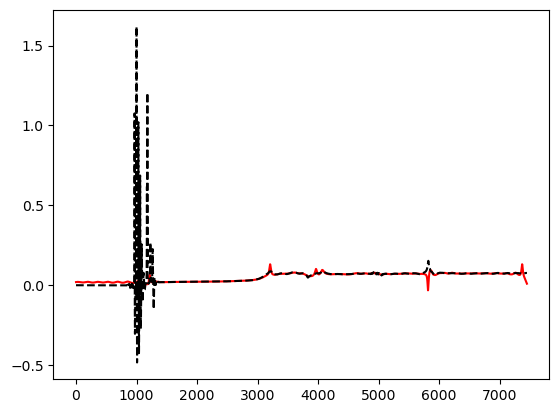

In [8]:
#Define id for which one to plot 
BAM_id = '0046'

#Define index
i=0

#Loop over files in file path
for file in glob.glob('./BAM_Catalog/Strain/R02/*.txt'):
    
    
    
    #Initial import to check number of columns
    df_test = pd.read_csv(file, delim_whitespace = True)
    
    
    #Check if number of columns in datafile is 9 or 7
    if len(df_test.columns) == 9:
        
        #Read data for datafile with 9 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        
        #Compute Phase
        df['phase_raw'] = -np.arctan2(df['Imh/M'], df['Reh/M'])
        #Unwrap to convert to continuously increasing form rather than modulo pi form
        df['phase'] = np.unwrap(df['phase_raw'])
        #Drop raw phase (i.e. phase modulo pi)
        df.drop(['phase_raw'], axis=1, inplace=True)
        
        
        #Compute Frequency
        #Change data type to float64
        df['t'] = df['t'].astype(np.float64)
        df['phase'] = df['phase'].astype(np.float64)
        #Compute Frequency as time derivative of phase (NOTE: This is angular frequency) 
        df['frequency'] = np.gradient(df['phase'], df['t'],edge_order=2)
        
        
        #Plot Frequency for run corresponding to BAM_id
        if BAM_id in file:
            print(file)
            
            plt.figure()
            plt.plot(df['t'], df['frequency'], color='r')
            plt.plot(df['t'], df['Momega']/Mass_List[i][0], color='k', linestyle='dashed')
            plt.show()
            plt.close()
        
        
        
    elif len(df_test.columns) == 7:
        
        #Read data for datafile with 7 columns 
        df = pd.read_csv(file, header=None, names=['u/M', 'Re', 'Im', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
        
        #Compute Phase
        df['phase_raw'] = -np.arctan2(df['Im'], df['Re'])
        #Unwrap to convert to continuously increasing form rather than modulo pi form
        df['phase'] = np.unwrap(df['phase_raw'])
        #Drop raw phase (i.e. phase modulo pi)
        df.drop(['phase_raw'], axis=1, inplace=True)
        
        
        #Compute Frequency
        #Convert data type to float64
        df['t'] = df['t'].astype(np.float64)
        df['phase'] = df['phase'].astype(np.float64)
        #Compute frequency as time derivative of phase (NOTE: This is angular frequency)
        df['frequency'] = np.gradient(df['phase'], df['t'],edge_order=2)
        
        
        #Plot Frequency for run corresponding to BAM_id
        if BAM_id in file:
            print(file)
            
            plt.figure()
            plt.plot(df['t'], df['frequency'], color='b')
            plt.plot(df['t'], df['Momega']/Mass_List[i][0], color='turquoise', linestyle='dashed')
            plt.show()
            plt.close()
        
    else:
        #Display error message if number of columns is not 9 or 7
        print('Error: Number of Columns Not Identified')

    #Update index
    i = i+1
        
#plt.title('WhiskyTHC Real Part vs. Code Time')


## Trimming and Translating Data

Now we want to trim and translate the data. Then we can start to plot the quantities against eachother.

In [9]:
#Define empty dictionary
h_Lev1 = {}

#Loop over files in file path
for file in glob.glob('./BAM_Catalog/Strain/R02/*.txt'):
    print(file)
    
    # Extract a meaningful identifier from the filename (e.g. the basename without the extension)
    identifier = file.split('/')[-1].replace('.txt', '').replace('_h', '')
    
    #Initial import to check number of columns
    df_test = pd.read_csv(file, delim_whitespace = True)
    
    #Check if number of columns is 9 or 7
    if len(df_test.columns) == 9:
        
        #Read data for datafile with 9 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Redh/M', 'Imdh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
        
    elif len(df_test.columns) == 7:
        
        #Read data for datafile with 7 columns
        df = pd.read_csv(file, header=None, names=['u/M', 'Reh/M', 'Imh/M', 'Momega', 'A/M', 'phi', 't'], delim_whitespace=True)
    
    #Add data to dictionary with identifier as the key
    h_Lev1[identifier] = df

./BAM_Catalog/Strain/R02\BAM0001_2B_1350_1350_h_r850.txt
./BAM_Catalog/Strain/R02\BAM0002_2H_1350_1350_h_r900.txt
./BAM_Catalog/Strain/R02\BAM0003_ALF2_1350_1350_h_r900.txt
./BAM_Catalog/Strain/R02\BAM0004_ALF2_1351_1351_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0005_ALF2_1375_1375_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0010_ALF2_1450_1250_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0011_ALF2_1500_1500_h_r800.txt
./BAM_Catalog/Strain/R02\BAM0012_ALF2_1528_1222_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0016_ALF2_1600_1600_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0017_ALF2_1650_1100_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0021_ALF2_1750_1000_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0022_ENG_1350_1350_h_r900.txt
./BAM_Catalog/Strain/R02\BAM0026_G2_1515_1515_h_r400.txt
./BAM_Catalog/Strain/R02\BAM0035_H4_1350_1350_h_r900.txt
./BAM_Catalog/Strain/R02\BAM0036_H4_1351_1351_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0037_H4_1372_1372_h_r1000.txt
./BAM_Catalog/Strain/R02\BAM0042_H4_1375_1375_h_r1000.txt
./

In [10]:
# Trim the data up to the first peak

# New directory for the trimmed time DataFrames
trimmed_data_path_Lev1 = './BAM_Catalog/Strain/Trimmed/R02'
trimmed_data_path = './BAM_Catalog/Strain/Trimmed'
# Create the directory if it doesn't exist
os.makedirs(trimmed_data_path_Lev1, exist_ok=True)

# Dictionary to hold the time of the first peak (of Real part) for each file
first_peak_times_Lev1 = {}

#print(h_Lev1)

#Loop over items in the h_Lev1 dictionary
for identifier, df in h_Lev1.items():
    # Find the peaks in the 'real_part' data
    
    #Check if maximum of real part is less than 1e-6 
    if max(df['Reh/M']) <= 1e-6:
        #Note: These are too small, but we kept for removal later
        peaks, _ = find_peaks(df['Reh/M'], height=5e-9)
    else:
        #Find peaks for the good files (i.e. correct order of magnitude)
        peaks, _ = find_peaks(df['Reh/M'], height=0.1)  # Find peaks above zero level
    
    if len(peaks) == 0:
        #Skip file if no peaks found (this removes it from further analysis)
        print(f"No peaks found in file: {identifier}. Skipping this file.")
        continue
    
    #Index of the first peak
    first_peak_index_Lev1 = peaks[0]
    
    #Time of the first peak
    first_peak_time_Lev1 = df.iloc[first_peak_index_Lev1]['t']
    first_peak_times_Lev1[identifier] = first_peak_time_Lev1
    
    #Trim the DataFrame to remove data before the first peak
    df_trimmed_Lev1 = df[df['t'] >= first_peak_time_Lev1].reset_index(drop=True)
    
    
    # Save the trimmed DataFrame to a new file
    trimmed_file_name_Lev1 = f"{identifier}_Trim.txt"
    trimmed_file_path_Lev1 = os.path.join(trimmed_data_path, trimmed_file_name_Lev1)
    df_trimmed_Lev1.to_csv(trimmed_file_path_Lev1, index=False, sep='\t')



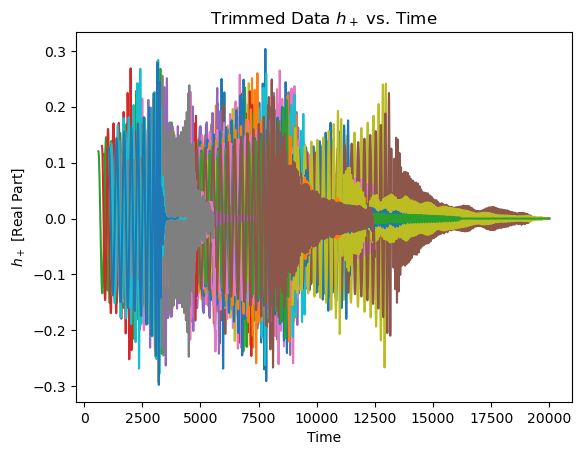

In [11]:
#Create Figure
plt.figure()

#Loop over files in file path
for file in glob.glob('./BAM_Catalog/Strain/Trimmed/R02/*_Trim.txt'):
    #print(file)
    
    #Read data in datafile
    df = pd.read_csv(file, sep='\t')
    
    #Plot Real Part
    plt.plot(df['t'], df['Reh/M'])

plt.title('Trimmed Data $h_+$ vs. Time')
plt.ylabel('$h_+$ [Real Part]')
plt.xlabel('Time')
plt.show()
plt.close()

./BAM_Catalog/Strain/Trimmed/R02\BAM0001_2B_1350_1350_r850_Trim.txt


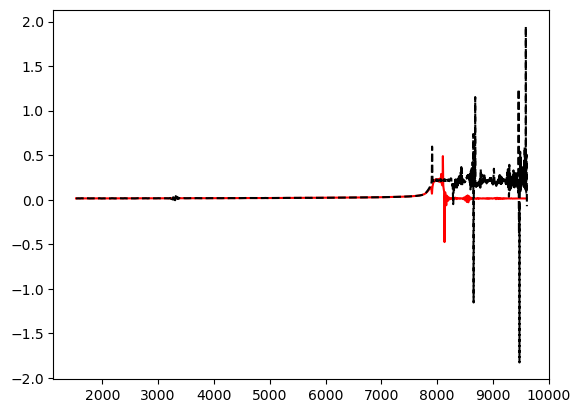

In [12]:
#Compute the phase and frequency and save

# New directory for the trimmed time DataFrames
trimmed_data_path_Lev1 = './BAM_Catalog/Strain/Frequency/R02'
trimmed_data_path = './BAM_Catalog/Strain/Frequency'
# Create the directory if it doesn't exist
os.makedirs(trimmed_data_path_Lev1, exist_ok=True)


#Define id for which one to plot 
BAM_id = '0001'

#Define index
i=0

#Loop over file in filepath
for file in glob.glob('./BAM_Catalog/Strain/Trimmed/R02/*_Trim.txt'):
    
    #define identifier
    identifier = file.replace('./BAM_Catalog/Strain/Trimmed/','').replace('.txt','')
    
    
    #Initial import to check number of columns
    df_test = pd.read_csv(file, delim_whitespace = True)
    
    #Check if data has 9 or 7 columns
    if len(df_test.columns) == 9:
        
        #Read data for datafile with 9 columns
        df = pd.read_csv(file, sep='\t')
        
        
        #Compute Amplitude (Note we have to multiply by the total mass)
        df['amplitude'] = np.sqrt((df['Reh/M']**2)+(df['Imh/M']**2))*Mass_List[i][0]
        
        
        #Compute Phase
        df['phase_raw'] = -np.arctan2(df['Imh/M'], df['Reh/M'])
        #Unwrap to convert to continuously increasing form rather than modulo pi form
        df['phase'] = np.unwrap(df['phase_raw'])
        #Drop raw phase (i.e. phase modulo pi)
        df.drop(['phase_raw'], axis=1, inplace=True)
        
        
        #Compute Frequency
        #Convert data type to float64
        df['t'] = df['t'].astype(np.float64)
        df['phase'] = df['phase'].astype(np.float64)
        #Compute frequency as time derivative of phase (NOTE: this is angular frequency)
        df['frequency'] = np.gradient(df['phase'], df['t'],edge_order=2)
        
        
        #Plot Frequency for run corresponding to BAM_id 
        if BAM_id in file:
            print(file)
            
            plt.figure()
            plt.plot(df['t'], df['frequency'], color='r')
            plt.plot(df['t'], df['Momega']/Mass_List[i][0], color='k', linestyle='dashed')
            plt.show()
            plt.close()
        
        
        
    elif len(df_test.columns) == 7:
        
        #Read data for datafile with 7 columns
        df = pd.read_csv(file, sep='\t')
        
        
        #Compute Amplitude (Note we have to multiply by the total mass)
        df['amplitude'] = np.sqrt((df['Reh/M']**2)+(df['Imh/M']**2))*Mass_List[i][0]
        
        
        #Compute Phase
        df['phase_raw'] = -np.arctan2(df['Imh/M'], df['Reh/M'])
        #Unwrap to convert to continuously increasing form rather than modulo pi form
        df['phase'] = np.unwrap(df['phase_raw'])
        #Drop raw phase (i.e. phase modulo pi)
        df.drop(['phase_raw'], axis=1, inplace=True)
        
        
        #Compute Frequency
        #Convert data type to float64
        df['t'] = df['t'].astype(np.float64)
        df['phase'] = df['phase'].astype(np.float64)
        #Compute frequency as time derivative of phase (NOTE: This is angular frequency)
        df['frequency'] = np.gradient(df['phase'], df['t'],edge_order=2)
        
        #Plot Frequency for run corresponding to BAM_id
        if BAM_id in file:
            print(file)
            
            plt.figure()
            plt.plot(df['t'], df['frequency'], color='b')
            plt.plot(df['t'], df['Momega']/Mass_List[i][0], color='turquoise', linestyle='dashed')
            plt.show()
            plt.close()
        
    else:
        #Display error message if number of columns is not 9 or 7
        print('Error: Number of Columns Not Identified')

    
    #Update Index
    i = i+1
    
    #Save Data with phase and frequency
    trimmed_file_name_Lev1 = f"{identifier}_Freq.txt"
    trimmed_file_path_Lev1 = os.path.join(trimmed_data_path, trimmed_file_name_Lev1)
    df.to_csv(trimmed_file_path_Lev1, index=False, sep='\t')
        
#plt.title('WhiskyTHC Real Part vs. Code Time')



In [13]:
#Translate The data

# for THC Fit 1
processed_data_path_Lev1 = './BAM_Catalog/Strain/Frequency/R02'

# Define an empty dictionary to store the data
processed_h_Lev1 = {}

# List all files in the processed data directory
for filename in os.listdir(processed_data_path_Lev1):
    if filename.endswith('.txt'):
        # Create a unique identifier for each waveform (e.g. by removing the file extension)
        identifier = filename[:-4]

        # Define the full path to the file
        file_path = os.path.join(processed_data_path_Lev1, filename)

        # Read the file into a pandas DataFrame
        # Assuming the data is tab-separated (adjust 'sep' if needed)
        df = pd.read_csv(file_path, sep='\t')

        # Store the DataFrame in the dictionary
        processed_h_Lev1[identifier] = df


In [14]:
# New directory for the translated time DataFrames
#for THC R01
translated_data_path_Lev1 = './BAM_Catalog/Strain/Translated/R02'  # Path to save the new files
os.makedirs(translated_data_path_Lev1, exist_ok=True) # Make sure the new directory exists, create it if it doesn't

# Translating the time and phase to start at 0
for identifier, df in processed_h_Lev1.items():
    # Translate time so that the time at common frequency becomes t=0
    df['t_translated'] = df['t'] - df.iloc[0]['t']
    df['phase_translated'] = df['phase'] - df.iloc[0]['phase']
    #df['amplitude_translated'] = df['amplitude']/df.iloc[0]['amplitude']
    
    # Define a new filename for saving
    new_filename = os.path.join(translated_data_path_Lev1, f"{identifier}_Time.txt")
    
    # Save the DataFrame with translated data to a file
    df.to_csv(new_filename, sep='\t')


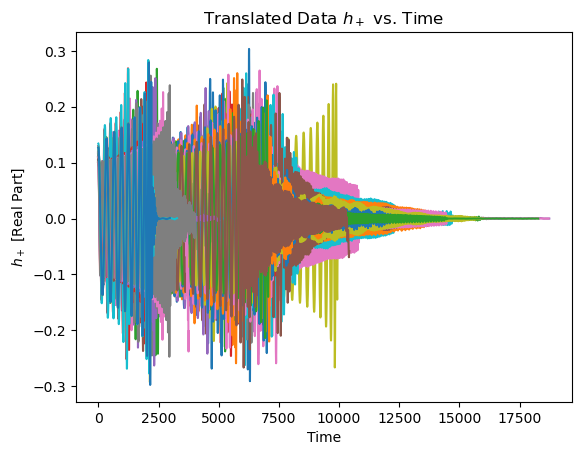

In [15]:
#Create Figure
plt.figure()

#Loop over files in filepath
for file in glob.glob('./BAM_Catalog/Strain/Translated/R02/*_Time.txt'):
    #print(file)
    
    #Read data from datafile
    df = pd.read_csv(file, sep='\t')
    
    #Plot Real part against translated time
    plt.plot(df['t_translated'], df['Reh/M'])

plt.title('Translated Data $h_+$ vs. Time')
plt.ylabel('$h_+$ [Real Part]')
plt.xlabel('Time')
plt.show()
plt.close()

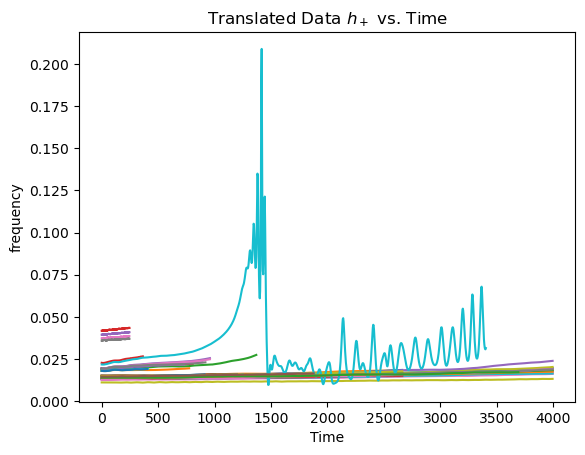

In [16]:
#Create Figure
plt.figure()

#Loop for file in filepath
for file in glob.glob('./BAM_Catalog/Strain/Translated/R02/*_Time.txt'):
    #print(file)
    
    #Read data from datafile
    df = pd.read_csv(file, sep='\t')
    
    #Define data slice
    df_slice = df[:1000]
    
    #Plot frequency against translated time for data slice
    plt.plot(df_slice['t_translated'], df_slice['frequency'])

plt.title('Translated Data $h_+$ vs. Time')
plt.ylabel('frequency')
plt.xlabel('Time')
plt.show()
plt.close()

## Merger Data

Now I want to identify the time of the merger for this translated time, and to find the frequency and amplitude at the merger time.

In [6]:
import os
#Define index
i = 0

#Create empty lists for key parameters
mrg_locations_Lev1 = []
mrg_phase_Lev1 = []
mrg_amplitude_Lev1 = []
mrg_frequency_Lev1 = []
mrg_labels_Lev1 = []
mrg_count_Lev1 = []
mrg_index_Lev1 = []
run_validity_Lev1 = []

#Loop over files in filepath
for file in glob.glob('./BAM_Catalog/Strain/Translated/R02/*_Time.txt'):
    
    #print(file)
    
    #Read data to DataFrame
    df = pd.read_csv(file, sep='\t')
    
    #index of maximum amplitude (i.e. index at merger time)
    ind_mrg = np.argmax(df['amplitude'])
    
    #Identify key merger values from index
    time_mrg = df['t_translated'][ind_mrg]
    freq_mrg = df['frequency'][ind_mrg]
    amp_mrg = df['amplitude'][ind_mrg]
    phase_mrg = df['phase_translated'][ind_mrg]
    
    label_mrg = file.split('/')[-1] #Removes the ./THC_Catalog/Strain/Translated/ part (keeps innermost folder and file)
    #print(label_mrg)
    
    #Because some of the runs are bad we will save an entry in the merger data that says whether the data is good
    valid = True
    #Check if run is one corresponding to the bad file
    for label in Bad_File_List:
        if label in file:
            valid = False
    
    #Append identified values to parameter lists
    mrg_locations_Lev1.append(time_mrg)
    mrg_phase_Lev1.append(phase_mrg)
    mrg_amplitude_Lev1.append(amp_mrg)
    mrg_frequency_Lev1.append(freq_mrg)
    mrg_labels_Lev1.append(label_mrg)
    mrg_count_Lev1.append(i)
    mrg_index_Lev1.append(ind_mrg)
    run_validity_Lev1.append(valid)
    
    #Update index
    i = i+1

# Combine the lists into a DataFrame
max_amp_df_Lev1 = pd.DataFrame({
    'File_Label': mrg_labels_Lev1,
    'EOS': mrg_count_Lev1,
    'Index_Merger': mrg_index_Lev1,
    'Time_Merger': mrg_locations_Lev1,
    'Amplitude_Merger': mrg_amplitude_Lev1,
    'Phase_Merger': mrg_phase_Lev1,
    'Frequency_Merger': mrg_frequency_Lev1,
    'Validity': run_validity_Lev1
})

# Define the new directory for the processed files
processed_files_path_Lev1 = './Strain_Processed/'

# Create the directory if it doesn't exist
os.makedirs(processed_files_path_Lev1, exist_ok=True)

# Specify the path for the output file within the new directory
output_file_path_Lev1 = os.path.join(processed_files_path_Lev1, 'Merger_Values_BAM_Lev2.txt')

## Save the DataFrame to a text file
max_amp_df_Lev1.to_csv(output_file_path_Lev1, index=False, sep='\t', header=True)

# Verify that the DataFrame looks correct
print(max_amp_df_Lev1.head())  # Just to check the first few rows    
 

                                          File_Label  EOS  Index_Merger  \
0   R02\BAM0001_2B_1350_1350_r850_Trim_Freq_Time.txt    0         12654   
1   R02\BAM0002_2H_1350_1350_r900_Trim_Freq_Time.txt    1          1591   
2  R02\BAM0003_ALF2_1350_1350_r900_Trim_Freq_Time...    2          5235   
3  R02\BAM0004_ALF2_1351_1351_r1000_Trim_Freq_Tim...    3          2461   
4  R02\BAM0005_ALF2_1375_1375_r1000_Trim_Freq_Tim...    4          1659   

   Time_Merger  Amplitude_Merger  Phase_Merger  Frequency_Merger  Validity  
0     6276.384          0.832798    133.145858          0.079043      True  
1     4085.688          0.545613     75.279547          0.038267      True  
2     5276.880          0.643859    104.195628          0.050634      True  
3     1988.488          0.657504     50.128937          0.051309      True  
4     6636.000          0.671142    122.475538          0.051971      True  


Now lets plot some of the trends in this data. to do this I first want to define the EOS and mass for each run.

In [18]:
#Define mass list
Mass_List = []

#Define list of equations of state
EOS_List = ['2B', '2H', 'ALF2', 'ENG', 'G2','G2k123', 'H4', 'MPA1', 'MS1', 'MS1b', 'SLy' ]

#Loop for files in filepath
for file in glob.glob('./BAM_Catalog/Strain/Translated/R02/*_Time.txt'):
    
    #Remove path terms to define identifier (will be used to identify masses)
    iden = file.replace('./BAM_Catalog/Strain/Translated/R02\\BAM', '').replace('_Trim_Freq_Time.txt', '')[5:]
    
    #Remove Extraction radius term (e.g. _r850)
    strings = iden.split('_')
    iden = iden.replace('_'+strings[-1], '')
    
    #print(iden)
    
    EOS_id = False
    #Loop over EOS_List
    for EOS in EOS_List:
        if EOS+'_' in iden:
            
            #Remove EOS from string
            mass_id = iden.replace(EOS+'_', '')
            EOS_id = True
            #print(mass_id)
            
            #Make list of the individual masses as a string
            masses = mass_id.split('_')
            #print(masses)
            
            #Convert mass data as strings to mass data as float in solar masses
            n = len(masses[0])  #Need to use this to determine scaling as files inconsitent with number of decimals
            masses[0] = int(masses[0])/(10**(n-1))
            masses[1] = int(masses[1])/(10**(n-1))
            #print(masses)
            
            #Compute Total Mass and Mass Ratio
            Mtotal = masses[0]+masses[1]
            q = masses[1]/masses[0]
            
            #Append list of totl mass and mass ratio to Mass_List
            Mass_List.append([Mtotal, q])
            
    if EOS_id == False:
        print(f"Error: No EOS Identified for {iden}")

#Check Total masses and mass ratios in Mass_List
print(Mass_List)

[[2.7, 1.0], [2.7, 1.0], [2.7, 1.0], [2.702, 1.0], [2.75, 1.0], [2.7, 0.8620689655172414], [3.0, 1.0], [2.75, 0.7997382198952879], [3.2, 1.0], [2.75, 0.6666666666666667], [2.75, 0.5714285714285714], [2.7, 1.0], [3.03, 1.0], [2.7, 1.0], [2.702, 1.0], [2.744, 1.0], [2.75, 1.0], [2.7009999999999996, 0.8627586206896551], [3.0, 1.0], [2.75, 0.7997382198952879], [3.2, 1.0], [2.75, 0.6666666666666667], [2.75, 0.5714285714285714], [2.7, 1.0], [2.7, 1.16], [2.7, 1.0], [2.702, 1.0], [2.7, 1.0], [2.7, 1.0], [2.75, 1.0], [2.5, 0.6666666666666666], [2.5, 0.6666666666666666], [3.0, 1.0], [2.7489999999999997, 0.8002619515389653], [3.2, 1.0], [2.75, 0.6666666666666667], [3.4, 1.0], [2.75, 0.5714285714285714], [2.888, 0.48559670781893005], [2.7, 1.0], [2.7, 1.0], [2.7, 1.0], [2.7, 1.0], [2.7, 1.0], [2.702, 1.0], [2.46, 0.8168389955686854], [2.75, 1.0], [2.7, 0.8620689655172414], [2.5, 0.6666666666666666], [3.0, 1.0], [2.7489999999999997, 0.8002619515389653], [2.748, 0.6654545454545455], [2.748, 0.66545

In [19]:
#Create list defining EOS for each run (type_list)

#Define index
i=0

#Listing of possible EOS for BAM data (Defined above already)
#EOS_List = ['2B', '2H', 'ALF2', 'ENG', 'G2','G2k123', 'H4', 'MPA1', 'MS1', 'MS1b', 'SLy' ]

#Define empty list
type_list = []

#Loop over files in filepath 
for file in sorted(glob.glob('./BAM_Catalog/Strain/Translated/R02/*_Time.txt')):
    
    #Set name variable equal to file (i.e. string)
    name = file

    if '2B' in name:
        type_list.append('2B')
    elif '2H' in name:
        type_list.append('2H')
    elif 'ALF2' in name:
        type_list.append('ALF2')
    elif 'ENG' in name:
        type_list.append('ENG')
    elif 'G2' in name:
        type_list.append('G2')
    elif 'Gk123' in name:
        type_list.append('Gk123')
    elif 'H4' in name:
        type_list.append('H4')
    elif 'MPA1' in name:
        type_list.append('MPA1')
    elif 'MS1b' in name:
        type_list.append('MS1b')
    elif 'MS1' in name:
        type_list.append('MS1')
    elif 'SLy' in name:
        type_list.append('SLy')
    else:
        print('Error: Deformability Type unknown')

    #update index
    i=i+1

print(type_list) 

['2B', '2H', 'ALF2', 'ALF2', 'ALF2', 'ALF2', 'ALF2', 'ALF2', 'ALF2', 'ALF2', 'ALF2', 'ENG', 'G2', 'H4', 'H4', 'H4', 'H4', 'H4', 'H4', 'H4', 'H4', 'H4', 'H4', 'MPA1', 'MS1', 'MS1', 'MS1', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'MS1b', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'SLy', 'MPA1', 'MPA1', 'MPA1']


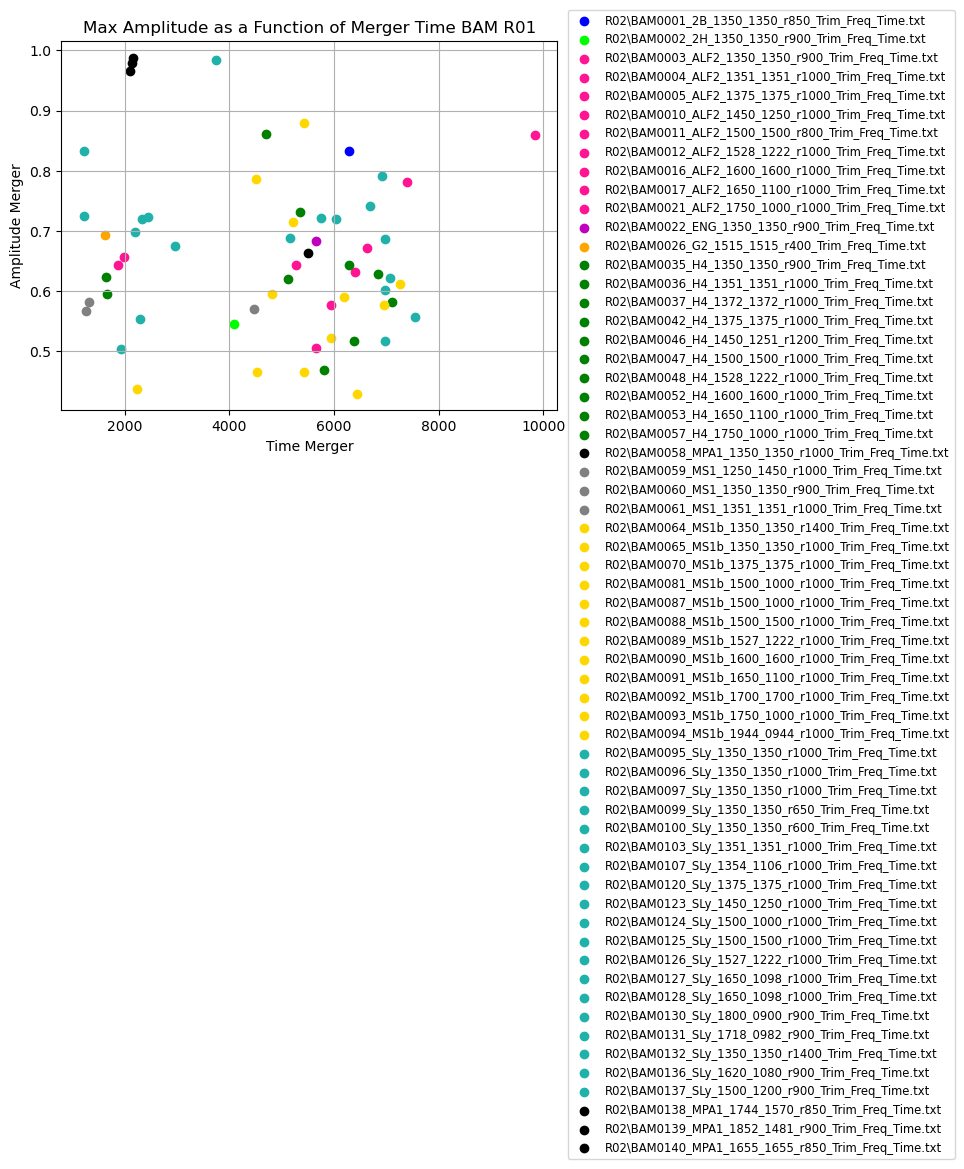

In [20]:
##EOS_List = ['2B', '2H', 'ALF2', 'ENG', 'G2','G2k123', 'H4', 'MPA1', 'MS1', 'MS1b', 'SLy' ]
# We'll use the previously created DataFrame
for index, row in max_amp_df_Lev1.iterrows():
    
    if type_list[index] == '2B':
        clr = 'b'
    elif type_list[index] == '2H':
        clr = 'lime'
    elif type_list[index] == 'ALF2':
        clr = 'deeppink'
    elif type_list[index] == 'ENG':
        clr = 'm'
    elif type_list[index] == 'G2':
        clr = 'orange'
    elif type_list[index] == 'Gk123':
        clr = 'r'
    elif type_list[index] == 'H4':
        clr = 'green'
    elif type_list[index] == 'MPA1':
        clr = 'k'
    elif type_list[index] == 'MS1':
        clr = 'grey'
    elif type_list[index] == 'MS1b':
        clr = 'gold'
    elif type_list[index] == 'SLy':
        clr = 'lightseagreen'
        
    #Check if the validity is True and if so plot (i.e. remove the identified bad runs)
    if row['Validity'] == True:    
        plt.scatter(row['Time_Merger'], row['Amplitude_Merger'], label=row['File_Label'], color=clr)

plt.xlabel('Time Merger')
plt.ylabel('Amplitude Merger')
plt.title('Max Amplitude as a Function of Merger Time BAM R01')
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.01, 1.1))
plt.grid(True)
plt.show()

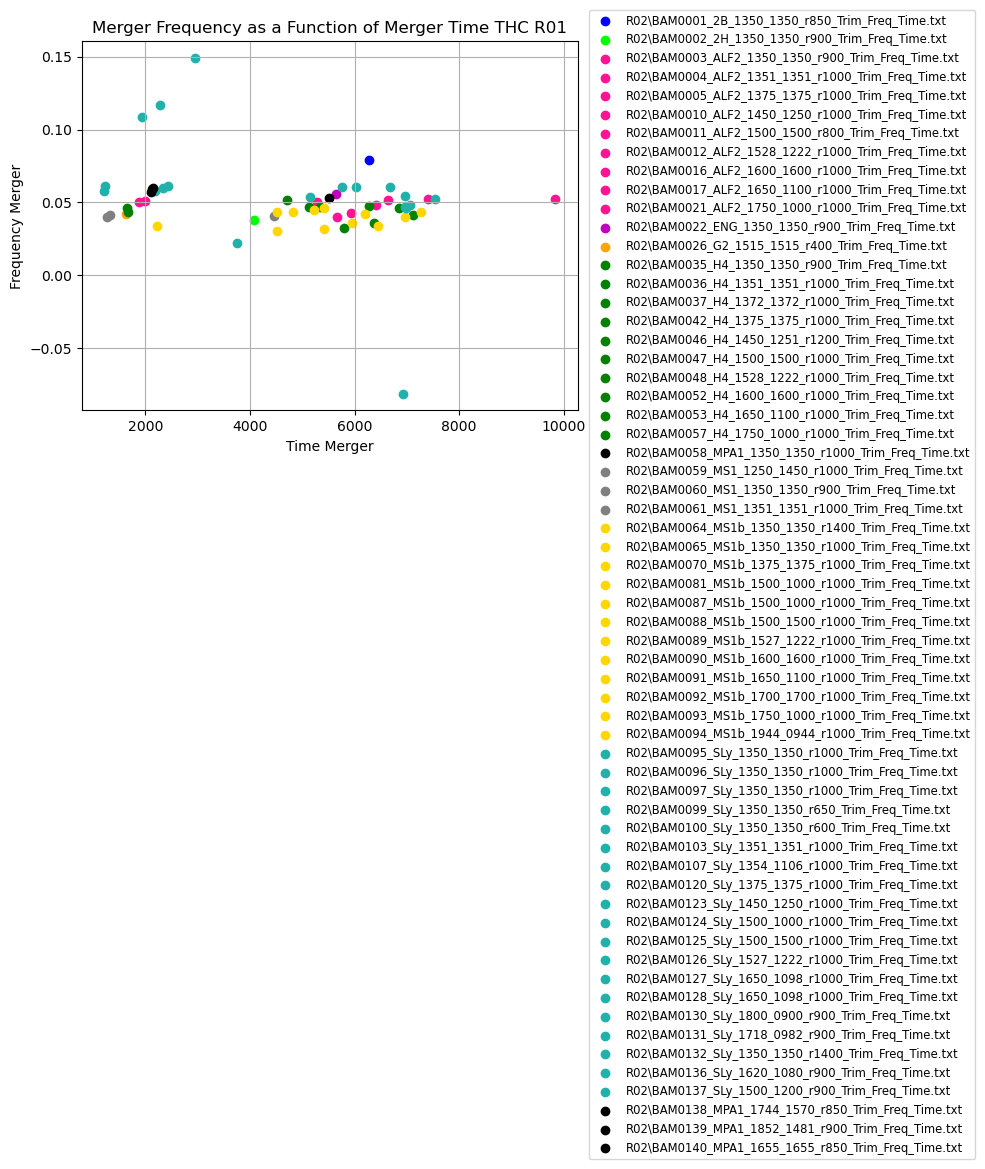

In [21]:
#EOS_List = ['BHBlp', 'DD2', 'LS220', 'MS1b', 'SFHo', 'SLy', 'BLh', 'BLQ', 'SLy4']
# We'll use the previously created DataFrame
for index, row in max_amp_df_Lev1.iterrows():
    
    if type_list[index] == '2B':
        clr = 'b'
    elif type_list[index] == '2H':
        clr = 'lime'
    elif type_list[index] == 'ALF2':
        clr = 'deeppink'
    elif type_list[index] == 'ENG':
        clr = 'm'
    elif type_list[index] == 'G2':
        clr = 'orange'
    elif type_list[index] == 'Gk123':
        clr = 'r'
    elif type_list[index] == 'H4':
        clr = 'green'
    elif type_list[index] == 'MPA1':
        clr = 'k'
    elif type_list[index] == 'MS1':
        clr = 'grey'
    elif type_list[index] == 'MS1b':
        clr = 'gold'
    elif type_list[index] == 'SLy':
        clr = 'lightseagreen'
        
    #Check if the validity is True and if so plot (i.e. remove the identified bad runs)
    if row['Validity'] == True:    
        plt.scatter(row['Time_Merger'], row['Frequency_Merger'], label=row['File_Label'], color=clr)

plt.xlabel('Time Merger')
plt.ylabel('Frequency Merger')
plt.title('Merger Frequency as a Function of Merger Time THC R01')
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.01, 1.1))
plt.grid(True)
plt.show()

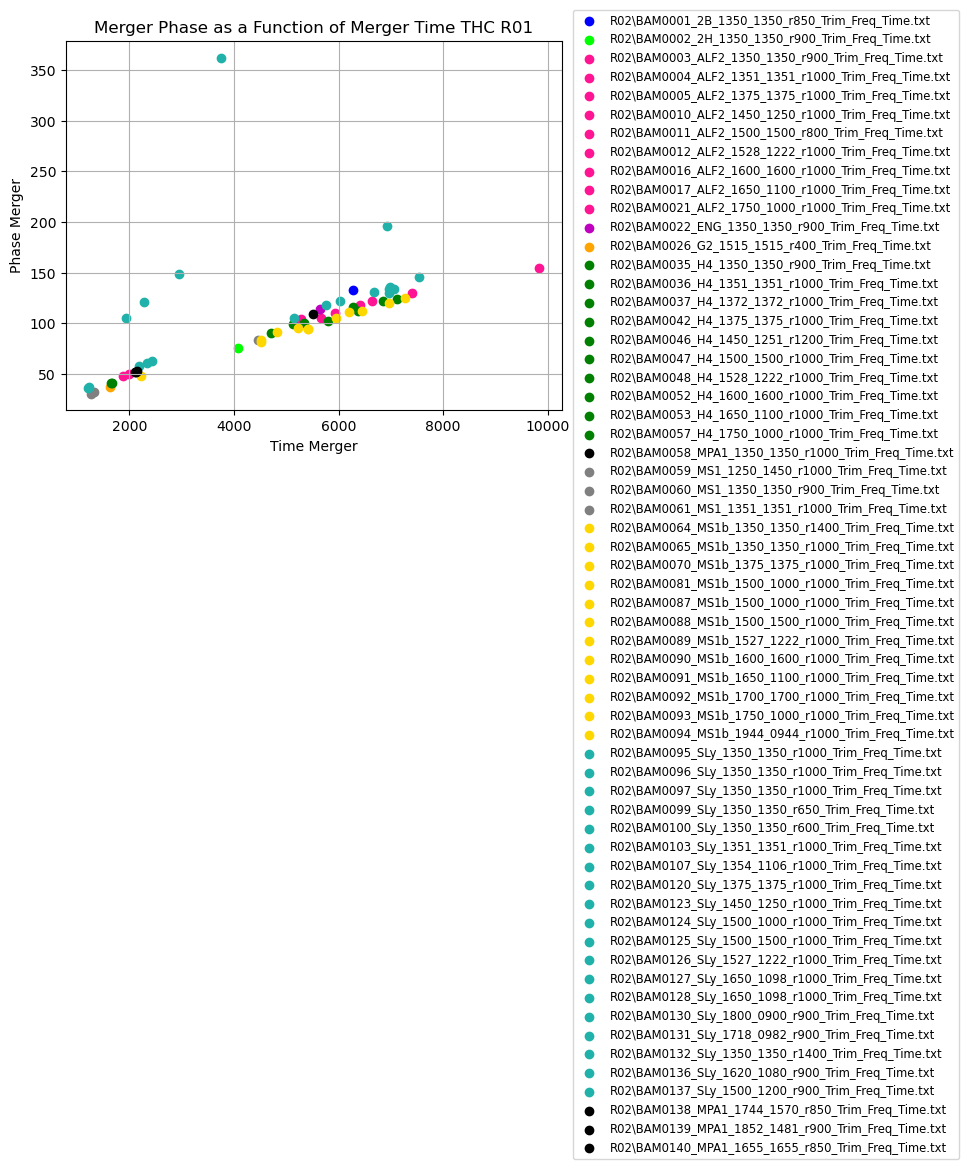

In [22]:
#EOS_List = ['BHBlp', 'DD2', 'LS220', 'MS1b', 'SFHo', 'SLy', 'BLh', 'BLQ', 'SLy4']
# We'll use the previously created DataFrame
for index, row in max_amp_df_Lev1.iterrows():
    
    if type_list[index] == '2B':
        clr = 'b'
    elif type_list[index] == '2H':
        clr = 'lime'
    elif type_list[index] == 'ALF2':
        clr = 'deeppink'
    elif type_list[index] == 'ENG':
        clr = 'm'
    elif type_list[index] == 'G2':
        clr = 'orange'
    elif type_list[index] == 'Gk123':
        clr = 'r'
    elif type_list[index] == 'H4':
        clr = 'green'
    elif type_list[index] == 'MPA1':
        clr = 'k'
    elif type_list[index] == 'MS1':
        clr = 'grey'
    elif type_list[index] == 'MS1b':
        clr = 'gold'
    elif type_list[index] == 'SLy':
        clr = 'lightseagreen'
        
    #Check if the validity is True and if so plot (i.e. remove the identified bad runs)
    if row['Validity'] == True:    
        plt.scatter(row['Time_Merger'], row['Phase_Merger'], label=row['File_Label'], color=clr)

plt.xlabel('Time Merger')
plt.ylabel('Phase Merger')
plt.title('Merger Phase as a Function of Merger Time THC R01')
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.01, 1.1))
plt.grid(True)
plt.show()

These plots (except the phase vs. time) don't show an obvious distinct trend, and this is likely because many of the runs were started with different initial conditions (i.e. some were started much earlier). Hence we don't really care about trends with the time (and phase).

Phase and Time have a linear relation as expected.

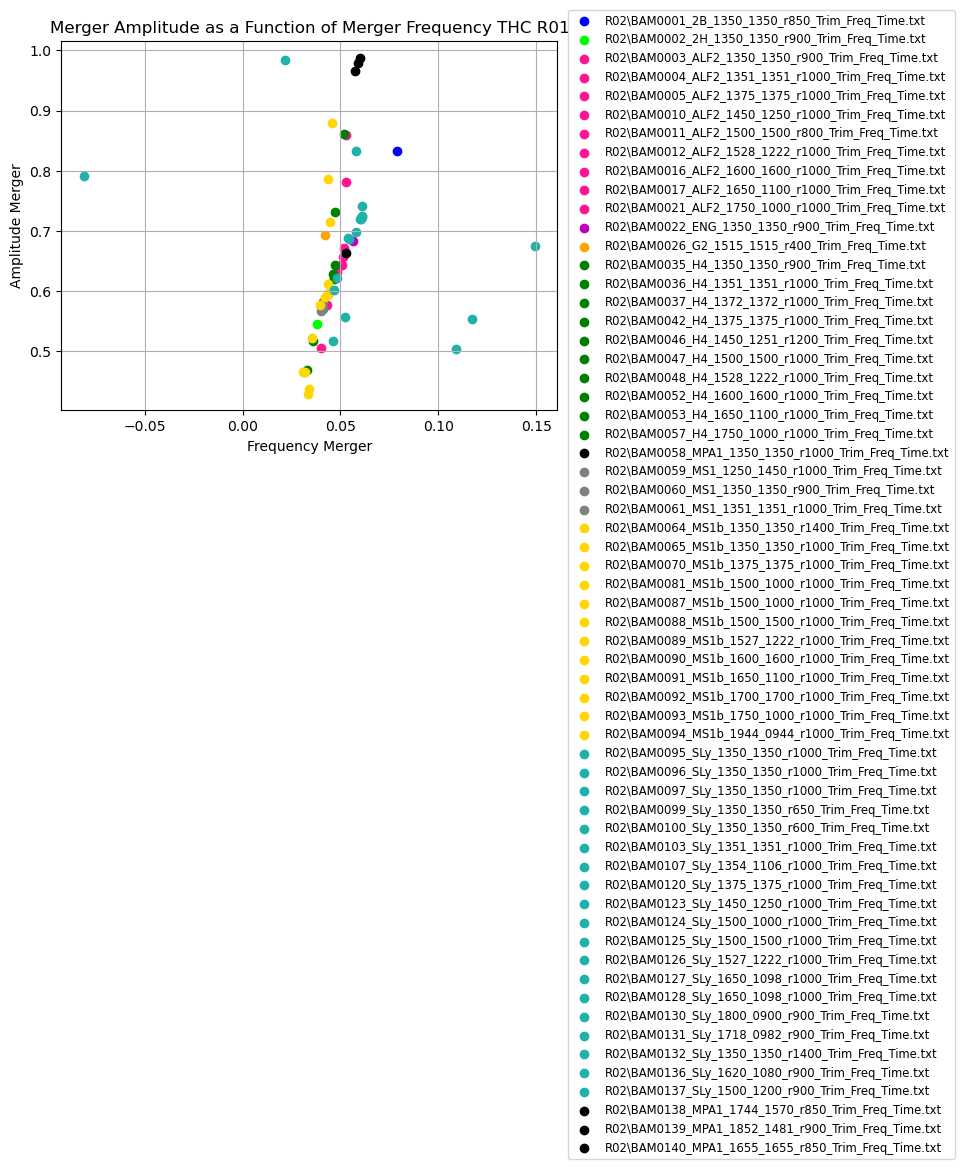

In [23]:
#EOS_List = ['BHBlp', 'DD2', 'LS220', 'MS1b', 'SFHo', 'SLy', 'BLh', 'BLQ', 'SLy4']
# We'll use the previously created DataFrame
for index, row in max_amp_df_Lev1.iterrows():
    
    if type_list[index] == '2B':
        clr = 'b'
    elif type_list[index] == '2H':
        clr = 'lime'
    elif type_list[index] == 'ALF2':
        clr = 'deeppink'
    elif type_list[index] == 'ENG':
        clr = 'm'
    elif type_list[index] == 'Gk123':
        clr = 'r'
    elif type_list[index] == 'G2':
        clr = 'orange'
    elif type_list[index] == 'H4':
        clr = 'green'
    elif type_list[index] == 'MPA1':
        clr = 'k'
    elif type_list[index] == 'MS1':
        clr = 'grey'
    elif type_list[index] == 'MS1b':
        clr = 'gold'
    elif type_list[index] == 'SLy':
        clr = 'lightseagreen'
    
    
    #Check if the validity is True and if so plot (i.e. remove the identified bad runs)
    if row['Validity'] == True:    
        plt.scatter(row['Frequency_Merger'], row['Amplitude_Merger'], label=row['File_Label'], color=clr)

plt.xlabel('Frequency Merger')
plt.ylabel('Amplitude Merger')
plt.title('Merger Amplitude as a Function of Merger Frequency THC R01')
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.01, 1.1))
plt.grid(True)
plt.show()

Here we actually do see a pattern and we could probably find a fit for this.

## Max Frequency Data

Now I want to identify the maximum frequency

In [7]:
# Find location of maximum frequecy for each waveform

# Define the directory containing the trimmed data files
freq_data_path_Lev1 = './BAM_Catalog/Strain/Translated/R02/'
freq_data_pattern_Lev1 = freq_data_path_Lev1 + '*.txt'
freq_data_Lev1 = glob.glob(freq_data_pattern_Lev1)

#Define empty lists for key parameters
max_frequency_locations_Lev1 = []
max_frequency_values_Lev1 = []
max_frequency_labels_Lev1 = []
max_frequency_count_Lev1 = []
max_frequency_index_Lev1 = []
run_validity_Lev1 = []
max_frequency_amplitude = []

#Define index
max_count = 0

# Loop through each trimmed file
for file_path in freq_data_Lev1:
    
#    # Load the data from the file
    df = pd.read_csv(file_path, sep='\t')
    
    
    #Find peaks so that we can look for max freq between merger time and next peak
    
    #Define initial threshold height
    n = 0.1
    #Find peaks
    peaks,_ = find_peaks(df['amplitude'], n)
    
    #Redo for smaller threshold (n) if we don't have any peaks at all
    while len(peaks) < 1:
        n = n/10
        peaks,_ = find_peaks(df['amplitude'], n)
    
    #Redo for smaller threshold (n) if we don't have any peaks after merger
    #If n<1e-15 then we check for max frequency to the end of the data series
    while peaks[-1] <=  max_amp_df_Lev1['Index_Merger'][max_count] and n>1e-15:
        n = n/10
        peaks,_ = find_peaks(df['amplitude'], n)
        
    #Print number of peaks found and the file path
    print(len(peaks), ',', file_path)
    
    
    #Find index of first peak after merger
    if peaks[-1] <=  max_amp_df_Lev1['Index_Merger'][max_count]:
        #If the latest identified frequency peak is not after the merger time
        print('Merger to End of Series')
        #Define slice from merger time to end of series
        df_slice2 = df[max_amp_df_Lev1['Index_Merger'][max_count]:] #Failsafe if no peak after merger
    else:
        #If a frequency peak after the merger time was identified
        #Define peak index
        k = 0
        #Identify index of first peak in frequency after merger
        while peaks[k] <= max_amp_df_Lev1['Index_Merger'][max_count]:
            k = k+1
        #Define slice from merger time to first peak in frequency after merger
        df_slice2 = df[max_amp_df_Lev1['Index_Merger'][max_count]:peaks[k]]
    
    
    # Find the index of the maximum amplitude
    max_idx = np.argmin(df_slice2['amplitude'])+max_amp_df_Lev1['Index_Merger'][max_count]
    # Extract the time of the maximum amplitude
    max_location = df.loc[max_idx, 't_translated']
    # Extract the value of the maximum amplitude
    max_value = df.loc[max_idx, 'frequency']
    # Extract the label (file name) of the maximum amplitude
    min_amp = df.loc[max_idx, 'amplitude']
    max_label = file_path.split('/')[-1]
    max_count = max_count + 1
    
    valid = True
    #Check if run is one corresponding to the bad file
    for label in Bad_File_List:
        if label in file_path:
            valid = False

#    # Append the extracted data to the lists
    max_frequency_locations_Lev1.append(max_location)
    max_frequency_values_Lev1.append(max_value)
    max_frequency_labels_Lev1.append(max_label)
    max_frequency_count_Lev1.append(max_count)
    max_frequency_index_Lev1.append(max_idx)
    run_validity_Lev1.append(valid)
    max_frequency_amplitude.append(min_amp)

# Combine the lists into a DataFrame
max_freq_df_Lev1 = pd.DataFrame({
    'File_Label': max_frequency_labels_Lev1,
    'EOS': max_frequency_count_Lev1,
    'Index_Max': max_frequency_index_Lev1,
    'Time_of_Max_Frequency': max_frequency_locations_Lev1,
    'Max_Frequency': max_frequency_values_Lev1,
    'Min_Amplitude': max_frequency_amplitude,
    'Validity': run_validity_Lev1
})

# Define the new directory for the processed files
processed_freq_path_Lev1 = './Strain_Processed/'

# Create the directory if it doesn't exist
os.makedirs(processed_freq_path_Lev1, exist_ok=True)

# Specify the path for the output file within the new directory
output_freq_path_Lev1 = os.path.join(processed_freq_path_Lev1, 'Max_Frequencies_BAM_Lev2.txt')

## Save the DataFrame to a text file
max_freq_df_Lev1.to_csv(output_freq_path_Lev1, index=False, sep='\t', header=True)

# Verify that the DataFrame looks correct
print(max_freq_df_Lev1.head())  # Just to check the first few rows

26 , ./BAM_Catalog/Strain/Translated/R02\BAM0001_2B_1350_1350_r850_Trim_Freq_Time.txt
19 , ./BAM_Catalog/Strain/Translated/R02\BAM0002_2H_1350_1350_r900_Trim_Freq_Time.txt
26 , ./BAM_Catalog/Strain/Translated/R02\BAM0003_ALF2_1350_1350_r900_Trim_Freq_Time.txt
13 , ./BAM_Catalog/Strain/Translated/R02\BAM0004_ALF2_1351_1351_r1000_Trim_Freq_Time.txt
37 , ./BAM_Catalog/Strain/Translated/R02\BAM0005_ALF2_1375_1375_r1000_Trim_Freq_Time.txt
6 , ./BAM_Catalog/Strain/Translated/R02\BAM0010_ALF2_1450_1250_r1000_Trim_Freq_Time.txt
23 , ./BAM_Catalog/Strain/Translated/R02\BAM0011_ALF2_1500_1500_r800_Trim_Freq_Time.txt
18 , ./BAM_Catalog/Strain/Translated/R02\BAM0012_ALF2_1528_1222_r1000_Trim_Freq_Time.txt
46 , ./BAM_Catalog/Strain/Translated/R02\BAM0016_ALF2_1600_1600_r1000_Trim_Freq_Time.txt
29 , ./BAM_Catalog/Strain/Translated/R02\BAM0017_ALF2_1650_1100_r1000_Trim_Freq_Time.txt
14 , ./BAM_Catalog/Strain/Translated/R02\BAM0021_ALF2_1750_1000_r1000_Trim_Freq_Time.txt
27 , ./BAM_Catalog/Strain/Tran

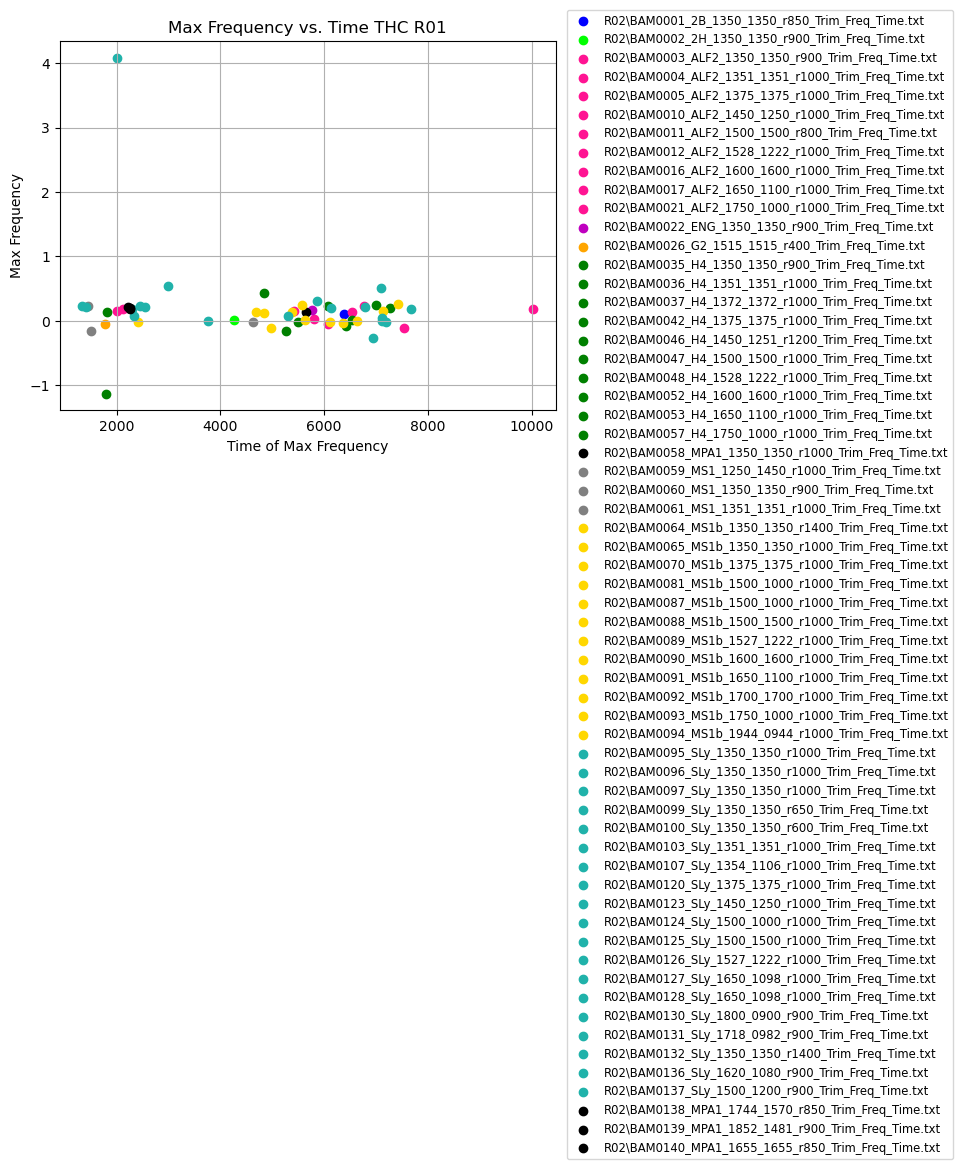

In [25]:
#EOS_List = ['BHBlp', 'DD2', 'LS220', 'MS1b', 'SFHo', 'SLy', 'BLh', 'BLQ', 'SLy4']
# We'll use the previously created DataFrame
for index, row in max_freq_df_Lev1.iterrows():
    
    if type_list[index] == '2B':
        clr = 'b'
    elif type_list[index] == '2H':
        clr = 'lime'
    elif type_list[index] == 'ALF2':
        clr = 'deeppink'
    elif type_list[index] == 'ENG':
        clr = 'm'
    elif type_list[index] == 'G2':
        clr = 'orange'
    elif type_list[index] == 'Gk123':
        clr = 'r'
    elif type_list[index] == 'H4':
        clr = 'green'
    elif type_list[index] == 'MPA1':
        clr = 'k'
    elif type_list[index] == 'MS1':
        clr = 'grey'
    elif type_list[index] == 'MS1b':
        clr = 'gold'
    elif type_list[index] == 'SLy':
        clr = 'lightseagreen'
        
    #Check if the validity is True and if so plot (i.e. remove the identified bad runs)
    if row['Validity'] == True:    
        plt.scatter(row['Time_of_Max_Frequency'], row['Max_Frequency'], label=row['File_Label'], color=clr)

plt.xlabel('Time of Max Frequency')
plt.ylabel('Max Frequency')
plt.title('Max Frequency vs. Time THC R01')
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.01, 1.1))
plt.grid(True)
plt.show()